In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (54, 829, 517)


(62, (829, 517, 62))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'station_count_y3', 'station_count_y4'])
len(lag_cols)

27

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG'])

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy)
        d_valid = lgb.Dataset(validX, label=validy)
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478, #478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=1
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('lgb_valid{}_preds'.format(j),'wb'))



1
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(5803, 1, 6) (5803, 7, 27) (5803, 1) (5803, 1)
(5803, 195) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.785458
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.766809
[3]	valid_0's rmse: 0.749554
[4]	valid_0's rmse: 0.733646
[5]	valid_0's rmse: 0.718798
[6]	valid_0's rmse: 0.705159
[7]	valid_0's rmse: 0.692598
[8]	valid_0's rmse: 0.680912
[9]	valid_0's rmse: 0.670256
[10]	valid_0's rmse: 0.660178
[11]	valid_0's rmse: 0.651188
[12]	valid_0's rmse: 0.642652
[13]	valid_0's rmse: 0.634925
[14]	valid_0's rmse: 0.627849
[15]	

[251]	valid_0's rmse: 0.530571
[252]	valid_0's rmse: 0.530526
[253]	valid_0's rmse: 0.53051
[254]	valid_0's rmse: 0.530484
[255]	valid_0's rmse: 0.53044
[256]	valid_0's rmse: 0.530424
[257]	valid_0's rmse: 0.530436
[258]	valid_0's rmse: 0.530439
[259]	valid_0's rmse: 0.530466
[260]	valid_0's rmse: 0.530457
[261]	valid_0's rmse: 0.530455
[262]	valid_0's rmse: 0.530448
[263]	valid_0's rmse: 0.530439
[264]	valid_0's rmse: 0.530431
[265]	valid_0's rmse: 0.530441
[266]	valid_0's rmse: 0.530445
[267]	valid_0's rmse: 0.530435
[268]	valid_0's rmse: 0.530418
[269]	valid_0's rmse: 0.530398
[270]	valid_0's rmse: 0.530414
[271]	valid_0's rmse: 0.530413
[272]	valid_0's rmse: 0.530413
[273]	valid_0's rmse: 0.530412
[274]	valid_0's rmse: 0.530387
[275]	valid_0's rmse: 0.530384
[276]	valid_0's rmse: 0.530386
[277]	valid_0's rmse: 0.530366
[278]	valid_0's rmse: 0.530373
[279]	valid_0's rmse: 0.530373
[280]	valid_0's rmse: 0.530369
[281]	valid_0's rmse: 0.530368
[282]	valid_0's rmse: 0.530385
[283]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.879009  0.050101  0.260407    7  2017-04-16
472     2.507290  2.624312 -0.117021  0.269147    1  2017-04-17
473     2.661330  2.643659  0.017671  0.277901    2  2017-04-18
474     2.754815  2.696877  0.057938  0.239516    3  2017-04-19
475     2.713762  2.678064  0.035698  0.265586    4  2017-04-20
476     2.999000  2.971099  0.027901  0.165448    5  2017-04-21
477     3.075529  3.098006 -0.022477  0.203285    6  2017-04-22

0.240184250019


pred         y     error    error2  day        date
dayidx                                                         
471     2.879009  2.929110  0.050101  0.260407    7  2017-04-16
472     2.624312  2.507290 -0.117021  0.269147    1  2017-04-17
473     2.643659  2.661330  0.017671  0.277901    2  2017-04-18
474     2.696877  2.754815  0.057938  0.239516    3  2017-04-19
475     2.678064  2.713762  0.035698  0.265586    4  2017-04-20
476     2.971099  2.999000  0.027901  0.165448    5  2017-04-21
477     3.098006  3.075529 -0.022477  0.203285    6  2017-04-22

(829, 195)


2
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(6632, 1, 6) (6632, 7, 27) (6632, 1) (6632, 1)
(6632, 195) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.785742
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.767156
[3]	valid_0's rmse: 0.7

[241]	valid_0's rmse: 0.533036
[242]	valid_0's rmse: 0.533005
[243]	valid_0's rmse: 0.532964
[244]	valid_0's rmse: 0.532955
[245]	valid_0's rmse: 0.532918
[246]	valid_0's rmse: 0.532908
[247]	valid_0's rmse: 0.532889
[248]	valid_0's rmse: 0.532867
[249]	valid_0's rmse: 0.532863
[250]	valid_0's rmse: 0.532863
[251]	valid_0's rmse: 0.532864
[252]	valid_0's rmse: 0.532866
[253]	valid_0's rmse: 0.532865
[254]	valid_0's rmse: 0.532867
[255]	valid_0's rmse: 0.532879
[256]	valid_0's rmse: 0.532848
[257]	valid_0's rmse: 0.532835
[258]	valid_0's rmse: 0.532793
[259]	valid_0's rmse: 0.53282
[260]	valid_0's rmse: 0.532809
[261]	valid_0's rmse: 0.532796
[262]	valid_0's rmse: 0.532808
[263]	valid_0's rmse: 0.532795
[264]	valid_0's rmse: 0.532778
[265]	valid_0's rmse: 0.532775
[266]	valid_0's rmse: 0.532777
[267]	valid_0's rmse: 0.532766
[268]	valid_0's rmse: 0.532748
[269]	valid_0's rmse: 0.532723
[270]	valid_0's rmse: 0.532734
[271]	valid_0's rmse: 0.532755
[272]	valid_0's rmse: 0.532748
[273]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.865834  0.063276  0.265682    7  2017-04-16
472     2.507290  2.598049 -0.090759  0.266529    1  2017-04-17
473     2.661330  2.639356  0.021974  0.277472    2  2017-04-18
474     2.754815  2.703098  0.051717  0.237336    3  2017-04-19
475     2.713762  2.664173  0.049589  0.258306    4  2017-04-20
476     2.999000  2.979837  0.019163  0.164641    5  2017-04-21
477     3.075529  3.102077 -0.026548  0.205272    6  2017-04-22

0.239319706539


pred         y     error    error2  day        date
dayidx                                                         
471     2.865834  2.929110  0.063276  0.265682    7  2017-04-16
472     2.598049  2.507290 -0.090759  0.266529    1  2017-04-17
473     2.639356  2.661330  0.021974  0.277472    2  2017-04-18
474     2.703098  2.754815  0.051717  0.237336    3  2017-04-19
475     2.664173  2.713762  0.049589  0.258306    4  2017-04-20
476     2.979837  2.999000  0.019163  0.164641    5  2017-04-21
477     3.102077  3.075529 -0.026548  0.205272    6  2017-04-22

(829, 195)


3
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(7461, 1, 6) (7461, 7, 27) (7461, 1) (7461, 1)
(7461, 195) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786351
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.767709
[3]	valid_0's rmse: 0.7

[242]	valid_0's rmse: 0.532905
[243]	valid_0's rmse: 0.532901
[244]	valid_0's rmse: 0.532904
[245]	valid_0's rmse: 0.532888
[246]	valid_0's rmse: 0.532918
[247]	valid_0's rmse: 0.532922
[248]	valid_0's rmse: 0.532941
[249]	valid_0's rmse: 0.532932
[250]	valid_0's rmse: 0.53295
[251]	valid_0's rmse: 0.532943
[252]	valid_0's rmse: 0.532949
[253]	valid_0's rmse: 0.532958
[254]	valid_0's rmse: 0.532948
[255]	valid_0's rmse: 0.532927
[256]	valid_0's rmse: 0.532917
[257]	valid_0's rmse: 0.532925
[258]	valid_0's rmse: 0.532943
[259]	valid_0's rmse: 0.532958
[260]	valid_0's rmse: 0.532925
[261]	valid_0's rmse: 0.532895
[262]	valid_0's rmse: 0.532889
[263]	valid_0's rmse: 0.532859
[264]	valid_0's rmse: 0.53284
[265]	valid_0's rmse: 0.532795
[266]	valid_0's rmse: 0.532791
[267]	valid_0's rmse: 0.532791
[268]	valid_0's rmse: 0.532789
[269]	valid_0's rmse: 0.532782
[270]	valid_0's rmse: 0.532768
[271]	valid_0's rmse: 0.532768
[272]	valid_0's rmse: 0.532745
[273]	valid_0's rmse: 0.532729
[274]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893022  0.036088  0.199073    7  2017-04-16
472     2.507290  2.610668 -0.103378  0.264087    1  2017-04-17
473     2.661330  2.636666  0.024664  0.279428    2  2017-04-18
474     2.754815  2.683437  0.071377  0.242555    3  2017-04-19
475     2.713762  2.652706  0.061055  0.267042    4  2017-04-20
476     2.999000  2.969162  0.029838  0.167840    5  2017-04-21
477     3.075529  3.102077 -0.026547  0.209787    6  2017-04-22

0.232830313611


pred         y     error    error2  day        date
dayidx                                                         
471     2.893022  2.929110  0.036088  0.199073    7  2017-04-16
472     2.610668  2.507290 -0.103378  0.264087    1  2017-04-17
473     2.636666  2.661330  0.024664  0.279428    2  2017-04-18
474     2.683437  2.754815  0.071377  0.242555    3  2017-04-19
475     2.652706  2.713762  0.061055  0.267042    4  2017-04-20
476     2.969162  2.999000  0.029838  0.167840    5  2017-04-21
477     3.102077  3.075529 -0.026547  0.209787    6  2017-04-22

(829, 195)


4
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(8290, 1, 6) (8290, 7, 27) (8290, 1) (8290, 1)
(8290, 195) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786024
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.767451
[3]	valid_0's rmse: 0.7

[242]	valid_0's rmse: 0.534261
[243]	valid_0's rmse: 0.534282
[244]	valid_0's rmse: 0.534241
[245]	valid_0's rmse: 0.534238
[246]	valid_0's rmse: 0.534202
[247]	valid_0's rmse: 0.534193
[248]	valid_0's rmse: 0.53421
[249]	valid_0's rmse: 0.534216
[250]	valid_0's rmse: 0.534217
[251]	valid_0's rmse: 0.534203
[252]	valid_0's rmse: 0.534182
[253]	valid_0's rmse: 0.534154
[254]	valid_0's rmse: 0.534126
[255]	valid_0's rmse: 0.534104
[256]	valid_0's rmse: 0.534077
[257]	valid_0's rmse: 0.534036
[258]	valid_0's rmse: 0.533991
[259]	valid_0's rmse: 0.53398
[260]	valid_0's rmse: 0.534017
[261]	valid_0's rmse: 0.534006
[262]	valid_0's rmse: 0.533993
[263]	valid_0's rmse: 0.533993
[264]	valid_0's rmse: 0.53398
[265]	valid_0's rmse: 0.533976
[266]	valid_0's rmse: 0.533978
[267]	valid_0's rmse: 0.533963
[268]	valid_0's rmse: 0.533948
[269]	valid_0's rmse: 0.533945
[270]	valid_0's rmse: 0.533951
[271]	valid_0's rmse: 0.533935
[272]	valid_0's rmse: 0.533899
[273]	valid_0's rmse: 0.533911
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892332  0.036778  0.190432    7  2017-04-16
472     2.507290  2.527705 -0.020415  0.190073    1  2017-04-17
473     2.661330  2.624716  0.036614  0.281541    2  2017-04-18
474     2.754815  2.701257  0.053558  0.239540    3  2017-04-19
475     2.713762  2.684314  0.029448  0.265594    4  2017-04-20
476     2.999000  2.959793  0.039206  0.168697    5  2017-04-21
477     3.075529  3.106760 -0.031231  0.208570    6  2017-04-22

0.220635202754


pred         y     error    error2  day        date
dayidx                                                         
471     2.892332  2.929110  0.036778  0.190432    7  2017-04-16
472     2.527705  2.507290 -0.020415  0.190073    1  2017-04-17
473     2.624716  2.661330  0.036614  0.281541    2  2017-04-18
474     2.701257  2.754815  0.053558  0.239540    3  2017-04-19
475     2.684314  2.713762  0.029448  0.265594    4  2017-04-20
476     2.959793  2.999000  0.039206  0.168697    5  2017-04-21
477     3.106760  3.075529 -0.031231  0.208570    6  2017-04-22

(829, 195)


5
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(9119, 1, 6) (9119, 7, 27) (9119, 1) (9119, 1)
(9119, 195) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786371
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.767862
[3]	valid_0's rmse: 0.7

[240]	valid_0's rmse: 0.535122
[241]	valid_0's rmse: 0.535111
[242]	valid_0's rmse: 0.535101
[243]	valid_0's rmse: 0.53508
[244]	valid_0's rmse: 0.535089
[245]	valid_0's rmse: 0.53505
[246]	valid_0's rmse: 0.535018
[247]	valid_0's rmse: 0.535027
[248]	valid_0's rmse: 0.534983
[249]	valid_0's rmse: 0.534979
[250]	valid_0's rmse: 0.534959
[251]	valid_0's rmse: 0.534901
[252]	valid_0's rmse: 0.53489
[253]	valid_0's rmse: 0.534901
[254]	valid_0's rmse: 0.534901
[255]	valid_0's rmse: 0.534904
[256]	valid_0's rmse: 0.53488
[257]	valid_0's rmse: 0.534854
[258]	valid_0's rmse: 0.534818
[259]	valid_0's rmse: 0.534842
[260]	valid_0's rmse: 0.5348
[261]	valid_0's rmse: 0.534809
[262]	valid_0's rmse: 0.534844
[263]	valid_0's rmse: 0.53488
[264]	valid_0's rmse: 0.534855
[265]	valid_0's rmse: 0.534877
[266]	valid_0's rmse: 0.534851
[267]	valid_0's rmse: 0.534845
[268]	valid_0's rmse: 0.534816
[269]	valid_0's rmse: 0.534789
[270]	valid_0's rmse: 0.534754
[271]	valid_0's rmse: 0.534741
[272]	valid_0's

[508]	valid_0's rmse: 0.533976
[509]	valid_0's rmse: 0.533981
[510]	valid_0's rmse: 0.53398
[511]	valid_0's rmse: 0.533963
[512]	valid_0's rmse: 0.533966
[513]	valid_0's rmse: 0.533949
[514]	valid_0's rmse: 0.533954
[515]	valid_0's rmse: 0.533973
[516]	valid_0's rmse: 0.533971
[517]	valid_0's rmse: 0.533987
[518]	valid_0's rmse: 0.533991
[519]	valid_0's rmse: 0.533982
[520]	valid_0's rmse: 0.533989
[521]	valid_0's rmse: 0.533996
[522]	valid_0's rmse: 0.534011
[523]	valid_0's rmse: 0.534001
[524]	valid_0's rmse: 0.533992
[525]	valid_0's rmse: 0.53401
[526]	valid_0's rmse: 0.533995
[527]	valid_0's rmse: 0.534014
[528]	valid_0's rmse: 0.534029
[529]	valid_0's rmse: 0.534026
[530]	valid_0's rmse: 0.534027
[531]	valid_0's rmse: 0.534045
[532]	valid_0's rmse: 0.534038
[533]	valid_0's rmse: 0.534036
[534]	valid_0's rmse: 0.534029
[535]	valid_0's rmse: 0.534053
[536]	valid_0's rmse: 0.53407
[537]	valid_0's rmse: 0.534064
[538]	valid_0's rmse: 0.534084
[539]	valid_0's rmse: 0.534079
[540]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906504  0.022606  0.181864    7  2017-04-16
472     2.507290  2.521034 -0.013743  0.172196    1  2017-04-17
473     2.661330  2.644106  0.017223  0.198395    2  2017-04-18
474     2.754815  2.708266  0.046549  0.236253    3  2017-04-19
475     2.713762  2.702079  0.011683  0.265459    4  2017-04-20
476     2.999000  2.938043  0.060956  0.172485    5  2017-04-21
477     3.075529  3.107647 -0.032118  0.204642    6  2017-04-22

0.204470572699


pred         y     error    error2  day        date
dayidx                                                         
471     2.906504  2.929110  0.022606  0.181864    7  2017-04-16
472     2.521034  2.507290 -0.013743  0.172196    1  2017-04-17
473     2.644106  2.661330  0.017223  0.198395    2  2017-04-18
474     2.708266  2.754815  0.046549  0.236253    3  2017-04-19
475     2.702079  2.713762  0.011683  0.265459    4  2017-04-20
476     2.938043  2.999000  0.060956  0.172485    5  2017-04-21
477     3.107647  3.075529 -0.032118  0.204642    6  2017-04-22

(829, 195)


6
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(9948, 1, 6) (9948, 7, 27) (9948, 1) (9948, 1)
(9948, 195) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786028
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.768036
[3]	valid_0's rmse: 0.7

[242]	valid_0's rmse: 0.53632
[243]	valid_0's rmse: 0.536314
[244]	valid_0's rmse: 0.536296
[245]	valid_0's rmse: 0.53629
[246]	valid_0's rmse: 0.536266
[247]	valid_0's rmse: 0.536207
[248]	valid_0's rmse: 0.536202
[249]	valid_0's rmse: 0.536181
[250]	valid_0's rmse: 0.536155
[251]	valid_0's rmse: 0.53614
[252]	valid_0's rmse: 0.536104
[253]	valid_0's rmse: 0.536115
[254]	valid_0's rmse: 0.536082
[255]	valid_0's rmse: 0.536071
[256]	valid_0's rmse: 0.536092
[257]	valid_0's rmse: 0.536131
[258]	valid_0's rmse: 0.536123
[259]	valid_0's rmse: 0.536094
[260]	valid_0's rmse: 0.536089
[261]	valid_0's rmse: 0.536076
[262]	valid_0's rmse: 0.536078
[263]	valid_0's rmse: 0.536039
[264]	valid_0's rmse: 0.536057
[265]	valid_0's rmse: 0.536054
[266]	valid_0's rmse: 0.536026
[267]	valid_0's rmse: 0.535997
[268]	valid_0's rmse: 0.536022
[269]	valid_0's rmse: 0.535993
[270]	valid_0's rmse: 0.536007
[271]	valid_0's rmse: 0.536007
[272]	valid_0's rmse: 0.536024
[273]	valid_0's rmse: 0.536004
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904665  0.024445  0.193882    7  2017-04-16
472     2.507290  2.530905 -0.023614  0.184907    1  2017-04-17
473     2.661330  2.648789  0.012541  0.209535    2  2017-04-18
474     2.754815  2.727213  0.027602  0.173699    3  2017-04-19
475     2.713762  2.689135  0.024626  0.267815    4  2017-04-20
476     2.999000  2.949819  0.049181  0.168318    5  2017-04-21
477     3.075529  3.106376 -0.030847  0.208438    6  2017-04-22

0.20094186927


pred         y     error    error2  day        date
dayidx                                                         
471     2.904665  2.929110  0.024445  0.193882    7  2017-04-16
472     2.530905  2.507290 -0.023614  0.184907    1  2017-04-17
473     2.648789  2.661330  0.012541  0.209535    2  2017-04-18
474     2.727213  2.754815  0.027602  0.173699    3  2017-04-19
475     2.689135  2.713762  0.024626  0.267815    4  2017-04-20
476     2.949819  2.999000  0.049181  0.168318    5  2017-04-21
477     3.106376  3.075529 -0.030847  0.208438    6  2017-04-22

(829, 195)


7
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(10777, 1, 6) (10777, 7, 27) (10777, 1) (10777, 1)
(10777, 195) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.785939
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.767766
[3]	valid_0's 

[242]	valid_0's rmse: 0.537849
[243]	valid_0's rmse: 0.537859
[244]	valid_0's rmse: 0.537834
[245]	valid_0's rmse: 0.537827
[246]	valid_0's rmse: 0.537803
[247]	valid_0's rmse: 0.537793
[248]	valid_0's rmse: 0.537778
[249]	valid_0's rmse: 0.537765
[250]	valid_0's rmse: 0.537717
[251]	valid_0's rmse: 0.53771
[252]	valid_0's rmse: 0.537678
[253]	valid_0's rmse: 0.537654
[254]	valid_0's rmse: 0.537664
[255]	valid_0's rmse: 0.537619
[256]	valid_0's rmse: 0.537598
[257]	valid_0's rmse: 0.537594
[258]	valid_0's rmse: 0.537596
[259]	valid_0's rmse: 0.537587
[260]	valid_0's rmse: 0.537594
[261]	valid_0's rmse: 0.537597
[262]	valid_0's rmse: 0.537578
[263]	valid_0's rmse: 0.537555
[264]	valid_0's rmse: 0.537535
[265]	valid_0's rmse: 0.537529
[266]	valid_0's rmse: 0.537522
[267]	valid_0's rmse: 0.537513
[268]	valid_0's rmse: 0.537515
[269]	valid_0's rmse: 0.537531
[270]	valid_0's rmse: 0.537552
[271]	valid_0's rmse: 0.537583
[272]	valid_0's rmse: 0.537565
[273]	valid_0's rmse: 0.537548
[274]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920472  0.008638  0.201782    7  2017-04-16
472     2.507290  2.556642 -0.049351  0.204354    1  2017-04-17
473     2.661330  2.643469  0.017861  0.222921    2  2017-04-18
474     2.754815  2.718663  0.036151  0.189979    3  2017-04-19
475     2.713762  2.705987  0.007775  0.213460    4  2017-04-20
476     2.999000  2.936916  0.062084  0.171044    5  2017-04-21
477     3.075529  3.103774 -0.028245  0.202975    6  2017-04-22

0.200930827545


pred         y     error    error2  day        date
dayidx                                                         
471     2.920472  2.929110  0.008638  0.201782    7  2017-04-16
472     2.556642  2.507290 -0.049351  0.204354    1  2017-04-17
473     2.643469  2.661330  0.017861  0.222921    2  2017-04-18
474     2.718663  2.754815  0.036151  0.189979    3  2017-04-19
475     2.705987  2.713762  0.007775  0.213460    4  2017-04-20
476     2.936916  2.999000  0.062084  0.171044    5  2017-04-21
477     3.103774  3.075529 -0.028245  0.202975    6  2017-04-22

(829, 195)


8
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(11606, 1, 6) (11606, 7, 27) (11606, 1) (11606, 1)
(11606, 195) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786708
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.76883
[3]	valid_0's r

[241]	valid_0's rmse: 0.541461
[242]	valid_0's rmse: 0.541488
[243]	valid_0's rmse: 0.541481
[244]	valid_0's rmse: 0.54147
[245]	valid_0's rmse: 0.541479
[246]	valid_0's rmse: 0.541465
[247]	valid_0's rmse: 0.541463
[248]	valid_0's rmse: 0.541447
[249]	valid_0's rmse: 0.541417
[250]	valid_0's rmse: 0.541375
[251]	valid_0's rmse: 0.541405
[252]	valid_0's rmse: 0.541407
[253]	valid_0's rmse: 0.541404
[254]	valid_0's rmse: 0.541391
[255]	valid_0's rmse: 0.541377
[256]	valid_0's rmse: 0.54137
[257]	valid_0's rmse: 0.541375
[258]	valid_0's rmse: 0.541344
[259]	valid_0's rmse: 0.541337
[260]	valid_0's rmse: 0.541327
[261]	valid_0's rmse: 0.541327
[262]	valid_0's rmse: 0.541293
[263]	valid_0's rmse: 0.541274
[264]	valid_0's rmse: 0.541297
[265]	valid_0's rmse: 0.541292
[266]	valid_0's rmse: 0.541283
[267]	valid_0's rmse: 0.541265
[268]	valid_0's rmse: 0.541212
[269]	valid_0's rmse: 0.54119
[270]	valid_0's rmse: 0.541194
[271]	valid_0's rmse: 0.541168
[272]	valid_0's rmse: 0.541133
[273]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930048 -0.000938  0.204942    7  2017-04-16
472     2.507290  2.560628 -0.053338  0.208248    1  2017-04-17
473     2.661330  2.655820  0.005510  0.220713    2  2017-04-18
474     2.754815  2.725136  0.029678  0.190849    3  2017-04-19
475     2.713762  2.710706  0.003056  0.205658    4  2017-04-20
476     2.999000  2.957465  0.041534  0.142013    5  2017-04-21
477     3.075529  3.109673 -0.034144  0.204480    6  2017-04-22

0.196700568212


pred         y     error    error2  day        date
dayidx                                                         
471     2.930048  2.929110 -0.000938  0.204942    7  2017-04-16
472     2.560628  2.507290 -0.053338  0.208248    1  2017-04-17
473     2.655820  2.661330  0.005510  0.220713    2  2017-04-18
474     2.725136  2.754815  0.029678  0.190849    3  2017-04-19
475     2.710706  2.713762  0.003056  0.205658    4  2017-04-20
476     2.957465  2.999000  0.041534  0.142013    5  2017-04-21
477     3.109673  3.075529 -0.034144  0.204480    6  2017-04-22

(829, 195)


9
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(12435, 1, 6) (12435, 7, 27) (12435, 1) (12435, 1)
(12435, 195) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786616
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.768782
[3]	valid_0's 

[241]	valid_0's rmse: 0.542515
[242]	valid_0's rmse: 0.542509
[243]	valid_0's rmse: 0.542538
[244]	valid_0's rmse: 0.542547
[245]	valid_0's rmse: 0.542516
[246]	valid_0's rmse: 0.542523
[247]	valid_0's rmse: 0.542495
[248]	valid_0's rmse: 0.54245
[249]	valid_0's rmse: 0.542409
[250]	valid_0's rmse: 0.542349
[251]	valid_0's rmse: 0.542336
[252]	valid_0's rmse: 0.542352
[253]	valid_0's rmse: 0.542319
[254]	valid_0's rmse: 0.54233
[255]	valid_0's rmse: 0.542333
[256]	valid_0's rmse: 0.542327
[257]	valid_0's rmse: 0.542325
[258]	valid_0's rmse: 0.542317
[259]	valid_0's rmse: 0.542343
[260]	valid_0's rmse: 0.542328
[261]	valid_0's rmse: 0.542284
[262]	valid_0's rmse: 0.542246
[263]	valid_0's rmse: 0.542263
[264]	valid_0's rmse: 0.542248
[265]	valid_0's rmse: 0.542251
[266]	valid_0's rmse: 0.542253
[267]	valid_0's rmse: 0.54222
[268]	valid_0's rmse: 0.542204
[269]	valid_0's rmse: 0.542195
[270]	valid_0's rmse: 0.54218
[271]	valid_0's rmse: 0.542155
[272]	valid_0's rmse: 0.542156
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932226 -0.003116  0.223851    7  2017-04-16
472     2.507290  2.566574 -0.059283  0.214119    1  2017-04-17
473     2.661330  2.666508 -0.005178  0.229950    2  2017-04-18
474     2.754815  2.729169  0.025645  0.201121    3  2017-04-19
475     2.713762  2.714111 -0.000350  0.213965    4  2017-04-20
476     2.999000  2.958231  0.040769  0.148926    5  2017-04-21
477     3.075529  3.085735 -0.010205  0.170460    6  2017-04-22

0.200341740811


pred         y     error    error2  day        date
dayidx                                                         
471     2.932226  2.929110 -0.003116  0.223851    7  2017-04-16
472     2.566574  2.507290 -0.059283  0.214119    1  2017-04-17
473     2.666508  2.661330 -0.005178  0.229950    2  2017-04-18
474     2.729169  2.754815  0.025645  0.201121    3  2017-04-19
475     2.714111  2.713762 -0.000350  0.213965    4  2017-04-20
476     2.958231  2.999000  0.040769  0.148926    5  2017-04-21
477     3.085735  3.075529 -0.010205  0.170460    6  2017-04-22

(829, 195)


10
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(13264, 1, 6) (13264, 7, 27) (13264, 1) (13264, 1)
(13264, 195) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.787146
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.769311
[3]	valid_0's

[241]	valid_0's rmse: 0.543234
[242]	valid_0's rmse: 0.543239
[243]	valid_0's rmse: 0.54323
[244]	valid_0's rmse: 0.543245
[245]	valid_0's rmse: 0.543216
[246]	valid_0's rmse: 0.543197
[247]	valid_0's rmse: 0.543202
[248]	valid_0's rmse: 0.54321
[249]	valid_0's rmse: 0.543204
[250]	valid_0's rmse: 0.543222
[251]	valid_0's rmse: 0.543179
[252]	valid_0's rmse: 0.54318
[253]	valid_0's rmse: 0.543148
[254]	valid_0's rmse: 0.543126
[255]	valid_0's rmse: 0.543124
[256]	valid_0's rmse: 0.543097
[257]	valid_0's rmse: 0.543096
[258]	valid_0's rmse: 0.543038
[259]	valid_0's rmse: 0.543014
[260]	valid_0's rmse: 0.543011
[261]	valid_0's rmse: 0.54305
[262]	valid_0's rmse: 0.543053
[263]	valid_0's rmse: 0.543035
[264]	valid_0's rmse: 0.543008
[265]	valid_0's rmse: 0.542968
[266]	valid_0's rmse: 0.542984
[267]	valid_0's rmse: 0.54297
[268]	valid_0's rmse: 0.542951
[269]	valid_0's rmse: 0.542926
[270]	valid_0's rmse: 0.542947
[271]	valid_0's rmse: 0.542946
[272]	valid_0's rmse: 0.542957
[273]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929803 -0.000693  0.213196    7  2017-04-16
472     2.507290  2.562977 -0.055687  0.209314    1  2017-04-17
473     2.661330  2.673949 -0.012619  0.231764    2  2017-04-18
474     2.754815  2.742237  0.012578  0.198224    3  2017-04-19
475     2.713762  2.727818 -0.014056  0.210914    4  2017-04-20
476     2.999000  2.954435  0.044564  0.145471    5  2017-04-21
477     3.075529  3.090481 -0.014952  0.164124    6  2017-04-22

0.196143922605


pred         y     error    error2  day        date
dayidx                                                         
471     2.929803  2.929110 -0.000693  0.213196    7  2017-04-16
472     2.562977  2.507290 -0.055687  0.209314    1  2017-04-17
473     2.673949  2.661330 -0.012619  0.231764    2  2017-04-18
474     2.742237  2.754815  0.012578  0.198224    3  2017-04-19
475     2.727818  2.713762 -0.014056  0.210914    4  2017-04-20
476     2.954435  2.999000  0.044564  0.145471    5  2017-04-21
477     3.090481  3.075529 -0.014952  0.164124    6  2017-04-22

(829, 195)


11
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(14093, 1, 6) (14093, 7, 27) (14093, 1) (14093, 1)
(14093, 195) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.7866
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.768781
[3]	valid_0's r

[241]	valid_0's rmse: 0.543829
[242]	valid_0's rmse: 0.543825
[243]	valid_0's rmse: 0.543843
[244]	valid_0's rmse: 0.543838
[245]	valid_0's rmse: 0.543851
[246]	valid_0's rmse: 0.54388
[247]	valid_0's rmse: 0.54391
[248]	valid_0's rmse: 0.54393
[249]	valid_0's rmse: 0.543913
[250]	valid_0's rmse: 0.543891
[251]	valid_0's rmse: 0.543901
[252]	valid_0's rmse: 0.543895
[253]	valid_0's rmse: 0.543898
[254]	valid_0's rmse: 0.543871
[255]	valid_0's rmse: 0.543884
[256]	valid_0's rmse: 0.543858
[257]	valid_0's rmse: 0.543865
[258]	valid_0's rmse: 0.543857
[259]	valid_0's rmse: 0.543827
[260]	valid_0's rmse: 0.543819
[261]	valid_0's rmse: 0.543816
[262]	valid_0's rmse: 0.543814
[263]	valid_0's rmse: 0.543805
[264]	valid_0's rmse: 0.54377
[265]	valid_0's rmse: 0.54374
[266]	valid_0's rmse: 0.543704
[267]	valid_0's rmse: 0.543692
[268]	valid_0's rmse: 0.543698
[269]	valid_0's rmse: 0.543684
[270]	valid_0's rmse: 0.543688
[271]	valid_0's rmse: 0.543661
[272]	valid_0's rmse: 0.543685
[273]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908582  0.020528  0.210707    7  2017-04-16
472     2.507290  2.574651 -0.067361  0.211670    1  2017-04-17
473     2.661330  2.661895 -0.000565  0.233546    2  2017-04-18
474     2.754815  2.747277  0.007537  0.199378    3  2017-04-19
475     2.713762  2.738024 -0.024263  0.216125    4  2017-04-20
476     2.999000  2.964937  0.034063  0.144097    5  2017-04-21
477     3.075529  3.075441  0.000089  0.165633    6  2017-04-22

0.197307934121


pred         y     error    error2  day        date
dayidx                                                         
471     2.908582  2.929110  0.020528  0.210707    7  2017-04-16
472     2.574651  2.507290 -0.067361  0.211670    1  2017-04-17
473     2.661895  2.661330 -0.000565  0.233546    2  2017-04-18
474     2.747277  2.754815  0.007537  0.199378    3  2017-04-19
475     2.738024  2.713762 -0.024263  0.216125    4  2017-04-20
476     2.964937  2.999000  0.034063  0.144097    5  2017-04-21
477     3.075441  3.075529  0.000089  0.165633    6  2017-04-22

(829, 195)


12
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(14922, 1, 6) (14922, 7, 27) (14922, 1) (14922, 1)
(14922, 195) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786587
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.768808
[3]	valid_0's

[240]	valid_0's rmse: 0.543835
[241]	valid_0's rmse: 0.543843
[242]	valid_0's rmse: 0.543827
[243]	valid_0's rmse: 0.543825
[244]	valid_0's rmse: 0.543841
[245]	valid_0's rmse: 0.543814
[246]	valid_0's rmse: 0.543809
[247]	valid_0's rmse: 0.543831
[248]	valid_0's rmse: 0.543815
[249]	valid_0's rmse: 0.543806
[250]	valid_0's rmse: 0.543802
[251]	valid_0's rmse: 0.543808
[252]	valid_0's rmse: 0.543799
[253]	valid_0's rmse: 0.5438
[254]	valid_0's rmse: 0.54378
[255]	valid_0's rmse: 0.54378
[256]	valid_0's rmse: 0.543818
[257]	valid_0's rmse: 0.543826
[258]	valid_0's rmse: 0.5438
[259]	valid_0's rmse: 0.543797
[260]	valid_0's rmse: 0.543786
[261]	valid_0's rmse: 0.543753
[262]	valid_0's rmse: 0.543796
[263]	valid_0's rmse: 0.543742
[264]	valid_0's rmse: 0.543734
[265]	valid_0's rmse: 0.543745
[266]	valid_0's rmse: 0.543726
[267]	valid_0's rmse: 0.543728
[268]	valid_0's rmse: 0.543717
[269]	valid_0's rmse: 0.543712
[270]	valid_0's rmse: 0.543717
[271]	valid_0's rmse: 0.543737
[272]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907103  0.022007  0.209076    7  2017-04-16
472     2.507290  2.561782 -0.054492  0.203330    1  2017-04-17
473     2.661330  2.668598 -0.007268  0.220883    2  2017-04-18
474     2.754815  2.732718  0.022096  0.191935    3  2017-04-19
475     2.713762  2.748528 -0.034766  0.210697    4  2017-04-20
476     2.999000  2.968456  0.030544  0.144173    5  2017-04-21
477     3.075529  3.087340 -0.011810  0.160935    6  2017-04-22

0.191575565265


pred         y     error    error2  day        date
dayidx                                                         
471     2.907103  2.929110  0.022007  0.209076    7  2017-04-16
472     2.561782  2.507290 -0.054492  0.203330    1  2017-04-17
473     2.668598  2.661330 -0.007268  0.220883    2  2017-04-18
474     2.732718  2.754815  0.022096  0.191935    3  2017-04-19
475     2.748528  2.713762 -0.034766  0.210697    4  2017-04-20
476     2.968456  2.999000  0.030544  0.144173    5  2017-04-21
477     3.087340  3.075529 -0.011810  0.160935    6  2017-04-22

(829, 195)


13
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(15751, 1, 6) (15751, 7, 27) (15751, 1) (15751, 1)
(15751, 195) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786634
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.769301
[3]	valid_0's

[241]	valid_0's rmse: 0.544417
[242]	valid_0's rmse: 0.544417
[243]	valid_0's rmse: 0.544357
[244]	valid_0's rmse: 0.544334
[245]	valid_0's rmse: 0.544323
[246]	valid_0's rmse: 0.54431
[247]	valid_0's rmse: 0.544331
[248]	valid_0's rmse: 0.544326
[249]	valid_0's rmse: 0.54431
[250]	valid_0's rmse: 0.544318
[251]	valid_0's rmse: 0.544278
[252]	valid_0's rmse: 0.544261
[253]	valid_0's rmse: 0.544237
[254]	valid_0's rmse: 0.544217
[255]	valid_0's rmse: 0.54419
[256]	valid_0's rmse: 0.5442
[257]	valid_0's rmse: 0.544229
[258]	valid_0's rmse: 0.544248
[259]	valid_0's rmse: 0.544256
[260]	valid_0's rmse: 0.544275
[261]	valid_0's rmse: 0.544272
[262]	valid_0's rmse: 0.544234
[263]	valid_0's rmse: 0.544207
[264]	valid_0's rmse: 0.544166
[265]	valid_0's rmse: 0.544163
[266]	valid_0's rmse: 0.544171
[267]	valid_0's rmse: 0.544171
[268]	valid_0's rmse: 0.544183
[269]	valid_0's rmse: 0.544174
[270]	valid_0's rmse: 0.544173
[271]	valid_0's rmse: 0.544169
[272]	valid_0's rmse: 0.544144
[273]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893346  0.035764  0.203982    7  2017-04-16
472     2.507290  2.554973 -0.047682  0.200757    1  2017-04-17
473     2.661330  2.668740 -0.007410  0.231443    2  2017-04-18
474     2.754815  2.739874  0.014940  0.199698    3  2017-04-19
475     2.713762  2.750443 -0.036682  0.216400    4  2017-04-20
476     2.999000  2.984605  0.014394  0.144847    5  2017-04-21
477     3.075529  3.078683 -0.003154  0.169508    6  2017-04-22

0.195233735113


pred         y     error    error2  day        date
dayidx                                                         
471     2.893346  2.929110  0.035764  0.203982    7  2017-04-16
472     2.554973  2.507290 -0.047682  0.200757    1  2017-04-17
473     2.668740  2.661330 -0.007410  0.231443    2  2017-04-18
474     2.739874  2.754815  0.014940  0.199698    3  2017-04-19
475     2.750443  2.713762 -0.036682  0.216400    4  2017-04-20
476     2.984605  2.999000  0.014394  0.144847    5  2017-04-21
477     3.078683  3.075529 -0.003154  0.169508    6  2017-04-22

(829, 195)


14
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(16580, 1, 6) (16580, 7, 27) (16580, 1) (16580, 1)
(16580, 195) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.786476
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.768831
[3]	valid_0's

[241]	valid_0's rmse: 0.544953
[242]	valid_0's rmse: 0.54494
[243]	valid_0's rmse: 0.544945
[244]	valid_0's rmse: 0.54493
[245]	valid_0's rmse: 0.544909
[246]	valid_0's rmse: 0.544933
[247]	valid_0's rmse: 0.544921
[248]	valid_0's rmse: 0.544944
[249]	valid_0's rmse: 0.544902
[250]	valid_0's rmse: 0.544904
[251]	valid_0's rmse: 0.544891
[252]	valid_0's rmse: 0.544876
[253]	valid_0's rmse: 0.544855
[254]	valid_0's rmse: 0.544832
[255]	valid_0's rmse: 0.544821
[256]	valid_0's rmse: 0.544818
[257]	valid_0's rmse: 0.544832
[258]	valid_0's rmse: 0.544818
[259]	valid_0's rmse: 0.544833
[260]	valid_0's rmse: 0.544825
[261]	valid_0's rmse: 0.544825
[262]	valid_0's rmse: 0.54483
[263]	valid_0's rmse: 0.544814
[264]	valid_0's rmse: 0.544769
[265]	valid_0's rmse: 0.544749
[266]	valid_0's rmse: 0.544717
[267]	valid_0's rmse: 0.544741
[268]	valid_0's rmse: 0.544738
[269]	valid_0's rmse: 0.544743
[270]	valid_0's rmse: 0.544751
[271]	valid_0's rmse: 0.544752
[272]	valid_0's rmse: 0.544767
[273]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897884  0.031226  0.224054    7  2017-04-16
472     2.507290  2.552814 -0.045524  0.217561    1  2017-04-17
473     2.661330  2.653233  0.008096  0.244723    2  2017-04-18
474     2.754815  2.731985  0.022830  0.209663    3  2017-04-19
475     2.713762  2.744154 -0.030392  0.229485    4  2017-04-20
476     2.999000  2.970586  0.028414  0.152395    5  2017-04-21
477     3.075529  3.081809 -0.006280  0.180021    6  2017-04-22

0.208271651778


pred         y     error    error2  day        date
dayidx                                                         
471     2.897884  2.929110  0.031226  0.224054    7  2017-04-16
472     2.552814  2.507290 -0.045524  0.217561    1  2017-04-17
473     2.653233  2.661330  0.008096  0.244723    2  2017-04-18
474     2.731985  2.754815  0.022830  0.209663    3  2017-04-19
475     2.744154  2.713762 -0.030392  0.229485    4  2017-04-20
476     2.970586  2.999000  0.028414  0.152395    5  2017-04-21
477     3.081809  3.075529 -0.006280  0.180021    6  2017-04-22

(829, 195)


15
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(17409, 1, 6) (17409, 7, 27) (17409, 1) (17409, 1)
(17409, 195) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.787188
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.769863
[3]	valid_0's

[240]	valid_0's rmse: 0.550443
[241]	valid_0's rmse: 0.550417
[242]	valid_0's rmse: 0.550406
[243]	valid_0's rmse: 0.550416
[244]	valid_0's rmse: 0.550422
[245]	valid_0's rmse: 0.550437
[246]	valid_0's rmse: 0.550433
[247]	valid_0's rmse: 0.550387
[248]	valid_0's rmse: 0.550381
[249]	valid_0's rmse: 0.550353
[250]	valid_0's rmse: 0.550337
[251]	valid_0's rmse: 0.550355
[252]	valid_0's rmse: 0.550369
[253]	valid_0's rmse: 0.550351
[254]	valid_0's rmse: 0.550356
[255]	valid_0's rmse: 0.550334
[256]	valid_0's rmse: 0.550342
[257]	valid_0's rmse: 0.55031
[258]	valid_0's rmse: 0.550303
[259]	valid_0's rmse: 0.550275
[260]	valid_0's rmse: 0.550264
[261]	valid_0's rmse: 0.550232
[262]	valid_0's rmse: 0.550227
[263]	valid_0's rmse: 0.550227
[264]	valid_0's rmse: 0.55022
[265]	valid_0's rmse: 0.550225
[266]	valid_0's rmse: 0.550233
[267]	valid_0's rmse: 0.550257
[268]	valid_0's rmse: 0.550254
[269]	valid_0's rmse: 0.550289
[270]	valid_0's rmse: 0.550286
[271]	valid_0's rmse: 0.550286
[272]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898862  0.030248  0.226027    7  2017-04-16
472     2.507290  2.554752 -0.047462  0.218292    1  2017-04-17
473     2.661330  2.663040 -0.001710  0.244300    2  2017-04-18
474     2.754815  2.729205  0.025610  0.197339    3  2017-04-19
475     2.713762  2.755395 -0.041634  0.229249    4  2017-04-20
476     2.999000  2.979173  0.019826  0.150198    5  2017-04-21
477     3.075529  3.080534 -0.005005  0.176824    6  2017-04-22

0.206032612863


pred         y     error    error2  day        date
dayidx                                                         
471     2.898862  2.929110  0.030248  0.226027    7  2017-04-16
472     2.554752  2.507290 -0.047462  0.218292    1  2017-04-17
473     2.663040  2.661330 -0.001710  0.244300    2  2017-04-18
474     2.729205  2.754815  0.025610  0.197339    3  2017-04-19
475     2.755395  2.713762 -0.041634  0.229249    4  2017-04-20
476     2.979173  2.999000  0.019826  0.150198    5  2017-04-21
477     3.080534  3.075529 -0.005005  0.176824    6  2017-04-22

(829, 195)


16
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(18238, 1, 6) (18238, 7, 27) (18238, 1) (18238, 1)
(18238, 195) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.787471
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770143
[3]	valid_0's

[241]	valid_0's rmse: 0.55258
[242]	valid_0's rmse: 0.552572
[243]	valid_0's rmse: 0.552588
[244]	valid_0's rmse: 0.552589
[245]	valid_0's rmse: 0.55254
[246]	valid_0's rmse: 0.552537
[247]	valid_0's rmse: 0.552524
[248]	valid_0's rmse: 0.552539
[249]	valid_0's rmse: 0.552568
[250]	valid_0's rmse: 0.552573
[251]	valid_0's rmse: 0.55255
[252]	valid_0's rmse: 0.552534
[253]	valid_0's rmse: 0.552524
[254]	valid_0's rmse: 0.552508
[255]	valid_0's rmse: 0.552494
[256]	valid_0's rmse: 0.552441
[257]	valid_0's rmse: 0.552477
[258]	valid_0's rmse: 0.552435
[259]	valid_0's rmse: 0.552439
[260]	valid_0's rmse: 0.552437
[261]	valid_0's rmse: 0.552442
[262]	valid_0's rmse: 0.552443
[263]	valid_0's rmse: 0.552415
[264]	valid_0's rmse: 0.552398
[265]	valid_0's rmse: 0.552391
[266]	valid_0's rmse: 0.552369
[267]	valid_0's rmse: 0.552357
[268]	valid_0's rmse: 0.552355
[269]	valid_0's rmse: 0.55234
[270]	valid_0's rmse: 0.552324
[271]	valid_0's rmse: 0.552303
[272]	valid_0's rmse: 0.552283
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893289  0.035821  0.211651    7  2017-04-16
472     2.507290  2.558015 -0.050725  0.203279    1  2017-04-17
473     2.661330  2.654834  0.006495  0.232903    2  2017-04-18
474     2.754815  2.717060  0.037754  0.190817    3  2017-04-19
475     2.713762  2.744037 -0.030276  0.215370    4  2017-04-20
476     2.999000  2.990655  0.008345  0.142008    5  2017-04-21
477     3.075529  3.076621 -0.001092  0.167145    6  2017-04-22

0.194739119382


pred         y     error    error2  day        date
dayidx                                                         
471     2.893289  2.929110  0.035821  0.211651    7  2017-04-16
472     2.558015  2.507290 -0.050725  0.203279    1  2017-04-17
473     2.654834  2.661330  0.006495  0.232903    2  2017-04-18
474     2.717060  2.754815  0.037754  0.190817    3  2017-04-19
475     2.744037  2.713762 -0.030276  0.215370    4  2017-04-20
476     2.990655  2.999000  0.008345  0.142008    5  2017-04-21
477     3.076621  3.075529 -0.001092  0.167145    6  2017-04-22

(829, 195)


17
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(19067, 1, 6) (19067, 7, 27) (19067, 1) (19067, 1)
(19067, 195) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.787942
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770626
[3]	valid_0's

[240]	valid_0's rmse: 0.552533
[241]	valid_0's rmse: 0.55255
[242]	valid_0's rmse: 0.552555
[243]	valid_0's rmse: 0.552549
[244]	valid_0's rmse: 0.55256
[245]	valid_0's rmse: 0.552557
[246]	valid_0's rmse: 0.552518
[247]	valid_0's rmse: 0.55252
[248]	valid_0's rmse: 0.552538
[249]	valid_0's rmse: 0.552526
[250]	valid_0's rmse: 0.552546
[251]	valid_0's rmse: 0.552522
[252]	valid_0's rmse: 0.552519
[253]	valid_0's rmse: 0.55246
[254]	valid_0's rmse: 0.552437
[255]	valid_0's rmse: 0.552384
[256]	valid_0's rmse: 0.552386
[257]	valid_0's rmse: 0.552402
[258]	valid_0's rmse: 0.552392
[259]	valid_0's rmse: 0.552386
[260]	valid_0's rmse: 0.552414
[261]	valid_0's rmse: 0.552395
[262]	valid_0's rmse: 0.552405
[263]	valid_0's rmse: 0.552396
[264]	valid_0's rmse: 0.552386
[265]	valid_0's rmse: 0.552379
[266]	valid_0's rmse: 0.552363
[267]	valid_0's rmse: 0.552356
[268]	valid_0's rmse: 0.552314
[269]	valid_0's rmse: 0.552317
[270]	valid_0's rmse: 0.552306
[271]	valid_0's rmse: 0.552286
[272]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891187  0.037923  0.213600    7  2017-04-16
472     2.507290  2.550139 -0.042849  0.208761    1  2017-04-17
473     2.661330  2.657514  0.003816  0.238257    2  2017-04-18
474     2.754815  2.718666  0.036149  0.196495    3  2017-04-19
475     2.713762  2.740419 -0.026657  0.221985    4  2017-04-20
476     2.999000  2.981148  0.017851  0.145049    5  2017-04-21
477     3.075529  3.068131  0.007398  0.169111    6  2017-04-22

0.199036820245


pred         y     error    error2  day        date
dayidx                                                         
471     2.891187  2.929110  0.037923  0.213600    7  2017-04-16
472     2.550139  2.507290 -0.042849  0.208761    1  2017-04-17
473     2.657514  2.661330  0.003816  0.238257    2  2017-04-18
474     2.718666  2.754815  0.036149  0.196495    3  2017-04-19
475     2.740419  2.713762 -0.026657  0.221985    4  2017-04-20
476     2.981148  2.999000  0.017851  0.145049    5  2017-04-21
477     3.068131  3.075529  0.007398  0.169111    6  2017-04-22

(829, 195)


18
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(19896, 1, 6) (19896, 7, 27) (19896, 1) (19896, 1)
(19896, 195) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.787543
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770298
[3]	valid_0's

[240]	valid_0's rmse: 0.553944
[241]	valid_0's rmse: 0.55389
[242]	valid_0's rmse: 0.553875
[243]	valid_0's rmse: 0.553904
[244]	valid_0's rmse: 0.553873
[245]	valid_0's rmse: 0.553831
[246]	valid_0's rmse: 0.553843
[247]	valid_0's rmse: 0.553856
[248]	valid_0's rmse: 0.553846
[249]	valid_0's rmse: 0.553838
[250]	valid_0's rmse: 0.553841
[251]	valid_0's rmse: 0.553824
[252]	valid_0's rmse: 0.553813
[253]	valid_0's rmse: 0.553823
[254]	valid_0's rmse: 0.553767
[255]	valid_0's rmse: 0.553721
[256]	valid_0's rmse: 0.553733
[257]	valid_0's rmse: 0.553737
[258]	valid_0's rmse: 0.553727
[259]	valid_0's rmse: 0.553691
[260]	valid_0's rmse: 0.553709
[261]	valid_0's rmse: 0.553653
[262]	valid_0's rmse: 0.553642
[263]	valid_0's rmse: 0.55363
[264]	valid_0's rmse: 0.553653
[265]	valid_0's rmse: 0.553658
[266]	valid_0's rmse: 0.55362
[267]	valid_0's rmse: 0.553627
[268]	valid_0's rmse: 0.553603
[269]	valid_0's rmse: 0.553592
[270]	valid_0's rmse: 0.553595
[271]	valid_0's rmse: 0.553579
[272]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878174  0.050936  0.228795    7  2017-04-16
472     2.507290  2.559152 -0.051862  0.216855    1  2017-04-17
473     2.661330  2.649465  0.011865  0.247939    2  2017-04-18
474     2.754815  2.712126  0.042688  0.205794    3  2017-04-19
475     2.713762  2.724814 -0.011052  0.226127    4  2017-04-20
476     2.999000  2.969013  0.029986  0.156437    5  2017-04-21
477     3.075529  3.054848  0.020681  0.180011    6  2017-04-22

0.208851202219


pred         y     error    error2  day        date
dayidx                                                         
471     2.878174  2.929110  0.050936  0.228795    7  2017-04-16
472     2.559152  2.507290 -0.051862  0.216855    1  2017-04-17
473     2.649465  2.661330  0.011865  0.247939    2  2017-04-18
474     2.712126  2.754815  0.042688  0.205794    3  2017-04-19
475     2.724814  2.713762 -0.011052  0.226127    4  2017-04-20
476     2.969013  2.999000  0.029986  0.156437    5  2017-04-21
477     3.054848  3.075529  0.020681  0.180011    6  2017-04-22

(829, 195)


19
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(20725, 1, 6) (20725, 7, 27) (20725, 1) (20725, 1)
(20725, 195) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.787519
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770293
[3]	valid_0's

[242]	valid_0's rmse: 0.553278
[243]	valid_0's rmse: 0.55324
[244]	valid_0's rmse: 0.553224
[245]	valid_0's rmse: 0.553178
[246]	valid_0's rmse: 0.553192
[247]	valid_0's rmse: 0.553173
[248]	valid_0's rmse: 0.553169
[249]	valid_0's rmse: 0.553179
[250]	valid_0's rmse: 0.553154
[251]	valid_0's rmse: 0.553151
[252]	valid_0's rmse: 0.553147
[253]	valid_0's rmse: 0.553169
[254]	valid_0's rmse: 0.55317
[255]	valid_0's rmse: 0.553156
[256]	valid_0's rmse: 0.553131
[257]	valid_0's rmse: 0.553095
[258]	valid_0's rmse: 0.553082
[259]	valid_0's rmse: 0.553057
[260]	valid_0's rmse: 0.553059
[261]	valid_0's rmse: 0.553078
[262]	valid_0's rmse: 0.553065
[263]	valid_0's rmse: 0.553024
[264]	valid_0's rmse: 0.553008
[265]	valid_0's rmse: 0.55301
[266]	valid_0's rmse: 0.553028
[267]	valid_0's rmse: 0.552983
[268]	valid_0's rmse: 0.552996
[269]	valid_0's rmse: 0.552927
[270]	valid_0's rmse: 0.552941
[271]	valid_0's rmse: 0.552938
[272]	valid_0's rmse: 0.552949
[273]	valid_0's rmse: 0.552964
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890236  0.038874  0.223527    7  2017-04-16
472     2.507290  2.547894 -0.040603  0.206695    1  2017-04-17
473     2.661330  2.654973  0.006357  0.240707    2  2017-04-18
474     2.754815  2.711791  0.043024  0.200267    3  2017-04-19
475     2.713762  2.724605 -0.010844  0.226186    4  2017-04-20
476     2.999000  2.970161  0.028839  0.154431    5  2017-04-21
477     3.075529  3.037422  0.038107  0.172189    6  2017-04-22

0.203428844702


pred         y     error    error2  day        date
dayidx                                                         
471     2.890236  2.929110  0.038874  0.223527    7  2017-04-16
472     2.547894  2.507290 -0.040603  0.206695    1  2017-04-17
473     2.654973  2.661330  0.006357  0.240707    2  2017-04-18
474     2.711791  2.754815  0.043024  0.200267    3  2017-04-19
475     2.724605  2.713762 -0.010844  0.226186    4  2017-04-20
476     2.970161  2.999000  0.028839  0.154431    5  2017-04-21
477     3.037422  3.075529  0.038107  0.172189    6  2017-04-22

(829, 195)


20
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(21554, 1, 6) (21554, 7, 27) (21554, 1) (21554, 1)
(21554, 195) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.787681
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770921
[3]	valid_0's

[242]	valid_0's rmse: 0.55466
[243]	valid_0's rmse: 0.554633
[244]	valid_0's rmse: 0.554672
[245]	valid_0's rmse: 0.554645
[246]	valid_0's rmse: 0.554639
[247]	valid_0's rmse: 0.554664
[248]	valid_0's rmse: 0.554663
[249]	valid_0's rmse: 0.554673
[250]	valid_0's rmse: 0.554648
[251]	valid_0's rmse: 0.554624
[252]	valid_0's rmse: 0.554616
[253]	valid_0's rmse: 0.55461
[254]	valid_0's rmse: 0.554601
[255]	valid_0's rmse: 0.55459
[256]	valid_0's rmse: 0.554569
[257]	valid_0's rmse: 0.554599
[258]	valid_0's rmse: 0.554595
[259]	valid_0's rmse: 0.554577
[260]	valid_0's rmse: 0.55462
[261]	valid_0's rmse: 0.554603
[262]	valid_0's rmse: 0.554593
[263]	valid_0's rmse: 0.554598
[264]	valid_0's rmse: 0.554603
[265]	valid_0's rmse: 0.554604
[266]	valid_0's rmse: 0.554579
[267]	valid_0's rmse: 0.554591
[268]	valid_0's rmse: 0.554597
[269]	valid_0's rmse: 0.554569
[270]	valid_0's rmse: 0.554542
[271]	valid_0's rmse: 0.55452
[272]	valid_0's rmse: 0.554521
[273]	valid_0's rmse: 0.554523
[274]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913976  0.015134  0.210596    7  2017-04-16
472     2.507290  2.548195 -0.040905  0.197629    1  2017-04-17
473     2.661330  2.648511  0.012819  0.227538    2  2017-04-18
474     2.754815  2.713854  0.040961  0.194946    3  2017-04-19
475     2.713762  2.718658 -0.004897  0.216221    4  2017-04-20
476     2.999000  2.957011  0.041989  0.145873    5  2017-04-21
477     3.075529  3.043964  0.031565  0.164321    6  2017-04-22

0.193875065471


pred         y     error    error2  day        date
dayidx                                                         
471     2.913976  2.929110  0.015134  0.210596    7  2017-04-16
472     2.548195  2.507290 -0.040905  0.197629    1  2017-04-17
473     2.648511  2.661330  0.012819  0.227538    2  2017-04-18
474     2.713854  2.754815  0.040961  0.194946    3  2017-04-19
475     2.718658  2.713762 -0.004897  0.216221    4  2017-04-20
476     2.957011  2.999000  0.041989  0.145873    5  2017-04-21
477     3.043964  3.075529  0.031565  0.164321    6  2017-04-22

(829, 195)


21
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(22383, 1, 6) (22383, 7, 27) (22383, 1) (22383, 1)
(22383, 195) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.787857
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.770864
[3]	valid_0's

[242]	valid_0's rmse: 0.555114
[243]	valid_0's rmse: 0.555112
[244]	valid_0's rmse: 0.555072
[245]	valid_0's rmse: 0.55506
[246]	valid_0's rmse: 0.555031
[247]	valid_0's rmse: 0.555038
[248]	valid_0's rmse: 0.555015
[249]	valid_0's rmse: 0.555018
[250]	valid_0's rmse: 0.555021
[251]	valid_0's rmse: 0.555002
[252]	valid_0's rmse: 0.554966
[253]	valid_0's rmse: 0.554956
[254]	valid_0's rmse: 0.554961
[255]	valid_0's rmse: 0.554915
[256]	valid_0's rmse: 0.55491
[257]	valid_0's rmse: 0.554903
[258]	valid_0's rmse: 0.554869
[259]	valid_0's rmse: 0.554843
[260]	valid_0's rmse: 0.554822
[261]	valid_0's rmse: 0.554816
[262]	valid_0's rmse: 0.554783
[263]	valid_0's rmse: 0.554789
[264]	valid_0's rmse: 0.554769
[265]	valid_0's rmse: 0.554751
[266]	valid_0's rmse: 0.554771
[267]	valid_0's rmse: 0.554765
[268]	valid_0's rmse: 0.554776
[269]	valid_0's rmse: 0.554779
[270]	valid_0's rmse: 0.554733
[271]	valid_0's rmse: 0.554724
[272]	valid_0's rmse: 0.554715
[273]	valid_0's rmse: 0.554741
[274]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900137  0.028973  0.215860    7  2017-04-16
472     2.507290  2.551316 -0.044026  0.203755    1  2017-04-17
473     2.661330  2.652074  0.009256  0.236636    2  2017-04-18
474     2.754815  2.714446  0.040369  0.198320    3  2017-04-19
475     2.713762  2.715842 -0.002080  0.221439    4  2017-04-20
476     2.999000  2.963918  0.035082  0.148518    5  2017-04-21
477     3.075529  3.028461  0.047069  0.171405    6  2017-04-22

0.199418967534


pred         y     error    error2  day        date
dayidx                                                         
471     2.900137  2.929110  0.028973  0.215860    7  2017-04-16
472     2.551316  2.507290 -0.044026  0.203755    1  2017-04-17
473     2.652074  2.661330  0.009256  0.236636    2  2017-04-18
474     2.714446  2.754815  0.040369  0.198320    3  2017-04-19
475     2.715842  2.713762 -0.002080  0.221439    4  2017-04-20
476     2.963918  2.999000  0.035082  0.148518    5  2017-04-21
477     3.028461  3.075529  0.047069  0.171405    6  2017-04-22

(829, 195)


22
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(23212, 1, 6) (23212, 7, 27) (23212, 1) (23212, 1)
(23212, 195) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.788329
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.771483
[3]	valid_0's

[241]	valid_0's rmse: 0.558953
[242]	valid_0's rmse: 0.558908
[243]	valid_0's rmse: 0.558927
[244]	valid_0's rmse: 0.558937
[245]	valid_0's rmse: 0.558937
[246]	valid_0's rmse: 0.558927
[247]	valid_0's rmse: 0.5589
[248]	valid_0's rmse: 0.55888
[249]	valid_0's rmse: 0.558872
[250]	valid_0's rmse: 0.558885
[251]	valid_0's rmse: 0.558841
[252]	valid_0's rmse: 0.558857
[253]	valid_0's rmse: 0.558834
[254]	valid_0's rmse: 0.558775
[255]	valid_0's rmse: 0.558815
[256]	valid_0's rmse: 0.558818
[257]	valid_0's rmse: 0.558816
[258]	valid_0's rmse: 0.558781
[259]	valid_0's rmse: 0.558773
[260]	valid_0's rmse: 0.558775
[261]	valid_0's rmse: 0.558784
[262]	valid_0's rmse: 0.558769
[263]	valid_0's rmse: 0.558774
[264]	valid_0's rmse: 0.558766
[265]	valid_0's rmse: 0.558758
[266]	valid_0's rmse: 0.55876
[267]	valid_0's rmse: 0.55871
[268]	valid_0's rmse: 0.558697
[269]	valid_0's rmse: 0.558721
[270]	valid_0's rmse: 0.558705
[271]	valid_0's rmse: 0.558706
[272]	valid_0's rmse: 0.558689
[273]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906952  0.022158  0.202576    7  2017-04-16
472     2.507290  2.542134 -0.034843  0.196830    1  2017-04-17
473     2.661330  2.646611  0.014719  0.223012    2  2017-04-18
474     2.754815  2.713629  0.041185  0.194604    3  2017-04-19
475     2.713762  2.721567 -0.007806  0.222782    4  2017-04-20
476     2.999000  2.960321  0.038679  0.152072    5  2017-04-21
477     3.075529  3.045489  0.030040  0.171244    6  2017-04-22

0.194731353189


pred         y     error    error2  day        date
dayidx                                                         
471     2.906952  2.929110  0.022158  0.202576    7  2017-04-16
472     2.542134  2.507290 -0.034843  0.196830    1  2017-04-17
473     2.646611  2.661330  0.014719  0.223012    2  2017-04-18
474     2.713629  2.754815  0.041185  0.194604    3  2017-04-19
475     2.721567  2.713762 -0.007806  0.222782    4  2017-04-20
476     2.960321  2.999000  0.038679  0.152072    5  2017-04-21
477     3.045489  3.075529  0.030040  0.171244    6  2017-04-22

(829, 195)


23
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(24041, 1, 6) (24041, 7, 27) (24041, 1) (24041, 1)
(24041, 195) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.788566
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.771733
[3]	valid_0's

[242]	valid_0's rmse: 0.560533
[243]	valid_0's rmse: 0.560552
[244]	valid_0's rmse: 0.560517
[245]	valid_0's rmse: 0.560487
[246]	valid_0's rmse: 0.560472
[247]	valid_0's rmse: 0.560458
[248]	valid_0's rmse: 0.560439
[249]	valid_0's rmse: 0.560449
[250]	valid_0's rmse: 0.560474
[251]	valid_0's rmse: 0.560462
[252]	valid_0's rmse: 0.560439
[253]	valid_0's rmse: 0.560439
[254]	valid_0's rmse: 0.560448
[255]	valid_0's rmse: 0.560429
[256]	valid_0's rmse: 0.560431
[257]	valid_0's rmse: 0.560419
[258]	valid_0's rmse: 0.560409
[259]	valid_0's rmse: 0.560432
[260]	valid_0's rmse: 0.560429
[261]	valid_0's rmse: 0.560438
[262]	valid_0's rmse: 0.560451
[263]	valid_0's rmse: 0.560462
[264]	valid_0's rmse: 0.560432
[265]	valid_0's rmse: 0.560447
[266]	valid_0's rmse: 0.560465
[267]	valid_0's rmse: 0.560466
[268]	valid_0's rmse: 0.560446
[269]	valid_0's rmse: 0.560426
[270]	valid_0's rmse: 0.560464
[271]	valid_0's rmse: 0.560487
[272]	valid_0's rmse: 0.560479
[273]	valid_0's rmse: 0.560479
[274]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905008  0.024102  0.213144    7  2017-04-16
472     2.507290  2.541412 -0.034121  0.196880    1  2017-04-17
473     2.661330  2.649584  0.011746  0.231059    2  2017-04-18
474     2.754815  2.720850  0.033965  0.198911    3  2017-04-19
475     2.713762  2.717973 -0.004212  0.222906    4  2017-04-20
476     2.999000  2.962310  0.036689  0.153851    5  2017-04-21
477     3.075529  3.039687  0.035842  0.172104    6  2017-04-22

0.198408069388


pred         y     error    error2  day        date
dayidx                                                         
471     2.905008  2.929110  0.024102  0.213144    7  2017-04-16
472     2.541412  2.507290 -0.034121  0.196880    1  2017-04-17
473     2.649584  2.661330  0.011746  0.231059    2  2017-04-18
474     2.720850  2.754815  0.033965  0.198911    3  2017-04-19
475     2.717973  2.713762 -0.004212  0.222906    4  2017-04-20
476     2.962310  2.999000  0.036689  0.153851    5  2017-04-21
477     3.039687  3.075529  0.035842  0.172104    6  2017-04-22

(829, 195)


24
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(24870, 1, 6) (24870, 7, 27) (24870, 1) (24870, 1)
(24870, 195) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789082
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.77231
[3]	valid_0's 

[242]	valid_0's rmse: 0.560898
[243]	valid_0's rmse: 0.560907
[244]	valid_0's rmse: 0.560903
[245]	valid_0's rmse: 0.560844
[246]	valid_0's rmse: 0.56083
[247]	valid_0's rmse: 0.56083
[248]	valid_0's rmse: 0.560823
[249]	valid_0's rmse: 0.56082
[250]	valid_0's rmse: 0.560783
[251]	valid_0's rmse: 0.560735
[252]	valid_0's rmse: 0.560723
[253]	valid_0's rmse: 0.560703
[254]	valid_0's rmse: 0.560695
[255]	valid_0's rmse: 0.560692
[256]	valid_0's rmse: 0.560698
[257]	valid_0's rmse: 0.560672
[258]	valid_0's rmse: 0.560701
[259]	valid_0's rmse: 0.560728
[260]	valid_0's rmse: 0.56069
[261]	valid_0's rmse: 0.560709
[262]	valid_0's rmse: 0.560721
[263]	valid_0's rmse: 0.560697
[264]	valid_0's rmse: 0.560675
[265]	valid_0's rmse: 0.560695
[266]	valid_0's rmse: 0.560669
[267]	valid_0's rmse: 0.560655
[268]	valid_0's rmse: 0.560658
[269]	valid_0's rmse: 0.560706
[270]	valid_0's rmse: 0.560709
[271]	valid_0's rmse: 0.560698
[272]	valid_0's rmse: 0.56067
[273]	valid_0's rmse: 0.560682
[274]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908911  0.020199  0.214100    7  2017-04-16
472     2.507290  2.543792 -0.036502  0.205080    1  2017-04-17
473     2.661330  2.633783  0.027547  0.238365    2  2017-04-18
474     2.754815  2.722255  0.032560  0.201974    3  2017-04-19
475     2.713762  2.714616 -0.000855  0.237505    4  2017-04-20
476     2.999000  2.958804  0.040196  0.159486    5  2017-04-21
477     3.075529  3.037413  0.038116  0.177788    6  2017-04-22

0.204899855249


pred         y     error    error2  day        date
dayidx                                                         
471     2.908911  2.929110  0.020199  0.214100    7  2017-04-16
472     2.543792  2.507290 -0.036502  0.205080    1  2017-04-17
473     2.633783  2.661330  0.027547  0.238365    2  2017-04-18
474     2.722255  2.754815  0.032560  0.201974    3  2017-04-19
475     2.714616  2.713762 -0.000855  0.237505    4  2017-04-20
476     2.958804  2.999000  0.040196  0.159486    5  2017-04-21
477     3.037413  3.075529  0.038116  0.177788    6  2017-04-22

(829, 195)


25
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(25699, 1, 6) (25699, 7, 27) (25699, 1) (25699, 1)
(25699, 195) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.7886
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.77185
[3]	valid_0's rm

[241]	valid_0's rmse: 0.561028
[242]	valid_0's rmse: 0.561
[243]	valid_0's rmse: 0.560997
[244]	valid_0's rmse: 0.561023
[245]	valid_0's rmse: 0.561003
[246]	valid_0's rmse: 0.561028
[247]	valid_0's rmse: 0.560984
[248]	valid_0's rmse: 0.560996
[249]	valid_0's rmse: 0.560958
[250]	valid_0's rmse: 0.560909
[251]	valid_0's rmse: 0.560882
[252]	valid_0's rmse: 0.560882
[253]	valid_0's rmse: 0.5609
[254]	valid_0's rmse: 0.560891
[255]	valid_0's rmse: 0.560868
[256]	valid_0's rmse: 0.560837
[257]	valid_0's rmse: 0.560828
[258]	valid_0's rmse: 0.560815
[259]	valid_0's rmse: 0.560816
[260]	valid_0's rmse: 0.560777
[261]	valid_0's rmse: 0.560765
[262]	valid_0's rmse: 0.560782
[263]	valid_0's rmse: 0.560777
[264]	valid_0's rmse: 0.560805
[265]	valid_0's rmse: 0.560807
[266]	valid_0's rmse: 0.560806
[267]	valid_0's rmse: 0.560825
[268]	valid_0's rmse: 0.5608
[269]	valid_0's rmse: 0.560798
[270]	valid_0's rmse: 0.560776
[271]	valid_0's rmse: 0.560776
[272]	valid_0's rmse: 0.560747
[273]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917842  0.011268  0.203863    7  2017-04-16
472     2.507290  2.537956 -0.030666  0.193442    1  2017-04-17
473     2.661330  2.653153  0.008177  0.225792    2  2017-04-18
474     2.754815  2.718616  0.036199  0.198237    3  2017-04-19
475     2.713762  2.710139  0.003623  0.227734    4  2017-04-20
476     2.999000  2.964304  0.034695  0.156064    5  2017-04-21
477     3.075529  3.049811  0.025718  0.173962    6  2017-04-22

0.197013208985


pred         y     error    error2  day        date
dayidx                                                         
471     2.917842  2.929110  0.011268  0.203863    7  2017-04-16
472     2.537956  2.507290 -0.030666  0.193442    1  2017-04-17
473     2.653153  2.661330  0.008177  0.225792    2  2017-04-18
474     2.718616  2.754815  0.036199  0.198237    3  2017-04-19
475     2.710139  2.713762  0.003623  0.227734    4  2017-04-20
476     2.964304  2.999000  0.034695  0.156064    5  2017-04-21
477     3.049811  3.075529  0.025718  0.173962    6  2017-04-22

(829, 195)


26
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(26528, 1, 6) (26528, 7, 27) (26528, 1) (26528, 1)
(26528, 195) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.788737
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.772103
[3]	valid_0's

[242]	valid_0's rmse: 0.561186
[243]	valid_0's rmse: 0.561205
[244]	valid_0's rmse: 0.561192
[245]	valid_0's rmse: 0.561206
[246]	valid_0's rmse: 0.561205
[247]	valid_0's rmse: 0.561161
[248]	valid_0's rmse: 0.56117
[249]	valid_0's rmse: 0.561153
[250]	valid_0's rmse: 0.561141
[251]	valid_0's rmse: 0.561134
[252]	valid_0's rmse: 0.561163
[253]	valid_0's rmse: 0.561124
[254]	valid_0's rmse: 0.561143
[255]	valid_0's rmse: 0.561122
[256]	valid_0's rmse: 0.561085
[257]	valid_0's rmse: 0.561097
[258]	valid_0's rmse: 0.561113
[259]	valid_0's rmse: 0.561121
[260]	valid_0's rmse: 0.561094
[261]	valid_0's rmse: 0.561082
[262]	valid_0's rmse: 0.56109
[263]	valid_0's rmse: 0.561095
[264]	valid_0's rmse: 0.561078
[265]	valid_0's rmse: 0.561074
[266]	valid_0's rmse: 0.561063
[267]	valid_0's rmse: 0.561052
[268]	valid_0's rmse: 0.561043
[269]	valid_0's rmse: 0.561035
[270]	valid_0's rmse: 0.561054
[271]	valid_0's rmse: 0.561039
[272]	valid_0's rmse: 0.561016
[273]	valid_0's rmse: 0.560991
[274]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920137  0.008973  0.210738    7  2017-04-16
472     2.507290  2.547161 -0.039871  0.196895    1  2017-04-17
473     2.661330  2.650815  0.010515  0.225486    2  2017-04-18
474     2.754815  2.718851  0.035964  0.191963    3  2017-04-19
475     2.713762  2.716274 -0.002512  0.215710    4  2017-04-20
476     2.999000  2.964151  0.034848  0.150050    5  2017-04-21
477     3.075529  3.062247  0.013282  0.168158    6  2017-04-22

0.194142822174


pred         y     error    error2  day        date
dayidx                                                         
471     2.920137  2.929110  0.008973  0.210738    7  2017-04-16
472     2.547161  2.507290 -0.039871  0.196895    1  2017-04-17
473     2.650815  2.661330  0.010515  0.225486    2  2017-04-18
474     2.718851  2.754815  0.035964  0.191963    3  2017-04-19
475     2.716274  2.713762 -0.002512  0.215710    4  2017-04-20
476     2.964151  2.999000  0.034848  0.150050    5  2017-04-21
477     3.062247  3.075529  0.013282  0.168158    6  2017-04-22

(829, 195)


27
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(27357, 1, 6) (27357, 7, 27) (27357, 1) (27357, 1)
(27357, 195) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.788534
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.772115
[3]	valid_0's

[240]	valid_0's rmse: 0.562294
[241]	valid_0's rmse: 0.562285
[242]	valid_0's rmse: 0.562287
[243]	valid_0's rmse: 0.56226
[244]	valid_0's rmse: 0.56226
[245]	valid_0's rmse: 0.562275
[246]	valid_0's rmse: 0.562256
[247]	valid_0's rmse: 0.562261
[248]	valid_0's rmse: 0.562273
[249]	valid_0's rmse: 0.56228
[250]	valid_0's rmse: 0.562281
[251]	valid_0's rmse: 0.562284
[252]	valid_0's rmse: 0.562259
[253]	valid_0's rmse: 0.562274
[254]	valid_0's rmse: 0.562265
[255]	valid_0's rmse: 0.562296
[256]	valid_0's rmse: 0.562293
[257]	valid_0's rmse: 0.562294
[258]	valid_0's rmse: 0.562325
[259]	valid_0's rmse: 0.562315
[260]	valid_0's rmse: 0.562347
[261]	valid_0's rmse: 0.56236
[262]	valid_0's rmse: 0.56236
[263]	valid_0's rmse: 0.562368
[264]	valid_0's rmse: 0.562372
[265]	valid_0's rmse: 0.56237
[266]	valid_0's rmse: 0.562392
[267]	valid_0's rmse: 0.562403
[268]	valid_0's rmse: 0.56241
[269]	valid_0's rmse: 0.562406
[270]	valid_0's rmse: 0.562378
[271]	valid_0's rmse: 0.56241
[272]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901591  0.027519  0.237114    7  2017-04-16
472     2.507290  2.558286 -0.050995  0.223331    1  2017-04-17
473     2.661330  2.656498  0.004832  0.246479    2  2017-04-18
474     2.754815  2.712407  0.042408  0.213767    3  2017-04-19
475     2.713762  2.710968  0.002794  0.240674    4  2017-04-20
476     2.999000  2.951363  0.047637  0.165959    5  2017-04-21
477     3.075529  3.060012  0.015518  0.187036    6  2017-04-22

0.216337027352


pred         y     error    error2  day        date
dayidx                                                         
471     2.901591  2.929110  0.027519  0.237114    7  2017-04-16
472     2.558286  2.507290 -0.050995  0.223331    1  2017-04-17
473     2.656498  2.661330  0.004832  0.246479    2  2017-04-18
474     2.712407  2.754815  0.042408  0.213767    3  2017-04-19
475     2.710968  2.713762  0.002794  0.240674    4  2017-04-20
476     2.951363  2.999000  0.047637  0.165959    5  2017-04-21
477     3.060012  3.075529  0.015518  0.187036    6  2017-04-22

(829, 195)


28
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(28186, 1, 6) (28186, 7, 27) (28186, 1) (28186, 1)
(28186, 195) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.788687
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.77211
[3]	valid_0's 

[240]	valid_0's rmse: 0.563685
[241]	valid_0's rmse: 0.563691
[242]	valid_0's rmse: 0.56367
[243]	valid_0's rmse: 0.563661
[244]	valid_0's rmse: 0.563622
[245]	valid_0's rmse: 0.563594
[246]	valid_0's rmse: 0.563602
[247]	valid_0's rmse: 0.563578
[248]	valid_0's rmse: 0.563558
[249]	valid_0's rmse: 0.563564
[250]	valid_0's rmse: 0.56359
[251]	valid_0's rmse: 0.563555
[252]	valid_0's rmse: 0.563561
[253]	valid_0's rmse: 0.563588
[254]	valid_0's rmse: 0.563578
[255]	valid_0's rmse: 0.563586
[256]	valid_0's rmse: 0.563538
[257]	valid_0's rmse: 0.563538
[258]	valid_0's rmse: 0.563513
[259]	valid_0's rmse: 0.563477
[260]	valid_0's rmse: 0.563486
[261]	valid_0's rmse: 0.563465
[262]	valid_0's rmse: 0.563442
[263]	valid_0's rmse: 0.563428
[264]	valid_0's rmse: 0.563421
[265]	valid_0's rmse: 0.563414
[266]	valid_0's rmse: 0.563403
[267]	valid_0's rmse: 0.563408
[268]	valid_0's rmse: 0.56339
[269]	valid_0's rmse: 0.563388
[270]	valid_0's rmse: 0.5634
[271]	valid_0's rmse: 0.563414
[272]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902011  0.027099  0.209980    7  2017-04-16
472     2.507290  2.552388 -0.045098  0.209158    1  2017-04-17
473     2.661330  2.661740 -0.000410  0.228229    2  2017-04-18
474     2.754815  2.719878  0.034937  0.196979    3  2017-04-19
475     2.713762  2.717437 -0.003676  0.231093    4  2017-04-20
476     2.999000  2.957404  0.041596  0.151725    5  2017-04-21
477     3.075529  3.059767  0.015762  0.173746    6  2017-04-22

0.200129890149


pred         y     error    error2  day        date
dayidx                                                         
471     2.902011  2.929110  0.027099  0.209980    7  2017-04-16
472     2.552388  2.507290 -0.045098  0.209158    1  2017-04-17
473     2.661740  2.661330 -0.000410  0.228229    2  2017-04-18
474     2.719878  2.754815  0.034937  0.196979    3  2017-04-19
475     2.717437  2.713762 -0.003676  0.231093    4  2017-04-20
476     2.957404  2.999000  0.041596  0.151725    5  2017-04-21
477     3.059767  3.075529  0.015762  0.173746    6  2017-04-22

(829, 195)


29
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(29015, 1, 6) (29015, 7, 27) (29015, 1) (29015, 1)
(29015, 195) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789133
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.772742
[3]	valid_0's

[241]	valid_0's rmse: 0.56729
[242]	valid_0's rmse: 0.567279
[243]	valid_0's rmse: 0.567282
[244]	valid_0's rmse: 0.567282
[245]	valid_0's rmse: 0.567268
[246]	valid_0's rmse: 0.567248
[247]	valid_0's rmse: 0.56726
[248]	valid_0's rmse: 0.567281
[249]	valid_0's rmse: 0.567274
[250]	valid_0's rmse: 0.567259
[251]	valid_0's rmse: 0.567246
[252]	valid_0's rmse: 0.567251
[253]	valid_0's rmse: 0.567204
[254]	valid_0's rmse: 0.567183
[255]	valid_0's rmse: 0.567151
[256]	valid_0's rmse: 0.567159
[257]	valid_0's rmse: 0.567159
[258]	valid_0's rmse: 0.567121
[259]	valid_0's rmse: 0.56712
[260]	valid_0's rmse: 0.567113
[261]	valid_0's rmse: 0.567089
[262]	valid_0's rmse: 0.567056
[263]	valid_0's rmse: 0.567068
[264]	valid_0's rmse: 0.567057
[265]	valid_0's rmse: 0.567036
[266]	valid_0's rmse: 0.567031
[267]	valid_0's rmse: 0.567026
[268]	valid_0's rmse: 0.567013
[269]	valid_0's rmse: 0.567029
[270]	valid_0's rmse: 0.567059
[271]	valid_0's rmse: 0.56707
[272]	valid_0's rmse: 0.567082
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887091  0.042019  0.208363    7  2017-04-16
472     2.507290  2.529509 -0.022219  0.202183    1  2017-04-17
473     2.661330  2.649512  0.011818  0.233012    2  2017-04-18
474     2.754815  2.727884  0.026931  0.197989    3  2017-04-19
475     2.713762  2.714764 -0.001002  0.215150    4  2017-04-20
476     2.999000  2.966659  0.032340  0.150739    5  2017-04-21
477     3.075529  3.057831  0.017698  0.170426    6  2017-04-22

0.196837551974


pred         y     error    error2  day        date
dayidx                                                         
471     2.887091  2.929110  0.042019  0.208363    7  2017-04-16
472     2.529509  2.507290 -0.022219  0.202183    1  2017-04-17
473     2.649512  2.661330  0.011818  0.233012    2  2017-04-18
474     2.727884  2.754815  0.026931  0.197989    3  2017-04-19
475     2.714764  2.713762 -0.001002  0.215150    4  2017-04-20
476     2.966659  2.999000  0.032340  0.150739    5  2017-04-21
477     3.057831  3.075529  0.017698  0.170426    6  2017-04-22

(829, 195)


30
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(29844, 1, 6) (29844, 7, 27) (29844, 1) (29844, 1)
(29844, 195) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789217
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.772926
[3]	valid_0's

[241]	valid_0's rmse: 0.566902
[242]	valid_0's rmse: 0.566899
[243]	valid_0's rmse: 0.566876
[244]	valid_0's rmse: 0.566855
[245]	valid_0's rmse: 0.566823
[246]	valid_0's rmse: 0.566812
[247]	valid_0's rmse: 0.566805
[248]	valid_0's rmse: 0.56682
[249]	valid_0's rmse: 0.566793
[250]	valid_0's rmse: 0.566789
[251]	valid_0's rmse: 0.566786
[252]	valid_0's rmse: 0.566811
[253]	valid_0's rmse: 0.56683
[254]	valid_0's rmse: 0.56687
[255]	valid_0's rmse: 0.566885
[256]	valid_0's rmse: 0.566884
[257]	valid_0's rmse: 0.566856
[258]	valid_0's rmse: 0.566845
[259]	valid_0's rmse: 0.566827
[260]	valid_0's rmse: 0.566816
[261]	valid_0's rmse: 0.566828
[262]	valid_0's rmse: 0.56681
[263]	valid_0's rmse: 0.566786
[264]	valid_0's rmse: 0.566747
[265]	valid_0's rmse: 0.566779
[266]	valid_0's rmse: 0.566751
[267]	valid_0's rmse: 0.566781
[268]	valid_0's rmse: 0.566778
[269]	valid_0's rmse: 0.566737
[270]	valid_0's rmse: 0.566728
[271]	valid_0's rmse: 0.566706
[272]	valid_0's rmse: 0.566695
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.868790  0.060320  0.209394    7  2017-04-16
472     2.507290  2.539331 -0.032040  0.210601    1  2017-04-17
473     2.661330  2.654546  0.006783  0.236052    2  2017-04-18
474     2.754815  2.718006  0.036808  0.201998    3  2017-04-19
475     2.713762  2.713197  0.000565  0.216713    4  2017-04-20
476     2.999000  2.970217  0.028783  0.150639    5  2017-04-21
477     3.075529  3.066279  0.009250  0.170295    6  2017-04-22

0.199384381751


pred         y     error    error2  day        date
dayidx                                                         
471     2.868790  2.929110  0.060320  0.209394    7  2017-04-16
472     2.539331  2.507290 -0.032040  0.210601    1  2017-04-17
473     2.654546  2.661330  0.006783  0.236052    2  2017-04-18
474     2.718006  2.754815  0.036808  0.201998    3  2017-04-19
475     2.713197  2.713762  0.000565  0.216713    4  2017-04-20
476     2.970217  2.999000  0.028783  0.150639    5  2017-04-21
477     3.066279  3.075529  0.009250  0.170295    6  2017-04-22

(829, 195)


31
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(30673, 1, 6) (30673, 7, 27) (30673, 1) (30673, 1)
(30673, 195) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789735
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.77326
[3]	valid_0's 

[240]	valid_0's rmse: 0.567897
[241]	valid_0's rmse: 0.567906
[242]	valid_0's rmse: 0.567934
[243]	valid_0's rmse: 0.567948
[244]	valid_0's rmse: 0.567954
[245]	valid_0's rmse: 0.567923
[246]	valid_0's rmse: 0.567904
[247]	valid_0's rmse: 0.567868
[248]	valid_0's rmse: 0.567854
[249]	valid_0's rmse: 0.56787
[250]	valid_0's rmse: 0.56788
[251]	valid_0's rmse: 0.567871
[252]	valid_0's rmse: 0.567846
[253]	valid_0's rmse: 0.567854
[254]	valid_0's rmse: 0.567862
[255]	valid_0's rmse: 0.567877
[256]	valid_0's rmse: 0.567839
[257]	valid_0's rmse: 0.567858
[258]	valid_0's rmse: 0.567832
[259]	valid_0's rmse: 0.567845
[260]	valid_0's rmse: 0.567856
[261]	valid_0's rmse: 0.567845
[262]	valid_0's rmse: 0.567866
[263]	valid_0's rmse: 0.567856
[264]	valid_0's rmse: 0.56785
[265]	valid_0's rmse: 0.567847
[266]	valid_0's rmse: 0.567841
[267]	valid_0's rmse: 0.567857
[268]	valid_0's rmse: 0.567876
[269]	valid_0's rmse: 0.567883
[270]	valid_0's rmse: 0.567909
[271]	valid_0's rmse: 0.567904
[272]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880466  0.048644  0.222826    7  2017-04-16
472     2.507290  2.542010 -0.034720  0.217699    1  2017-04-17
473     2.661330  2.643657  0.017673  0.248631    2  2017-04-18
474     2.754815  2.718609  0.036206  0.208809    3  2017-04-19
475     2.713762  2.718721 -0.004959  0.230910    4  2017-04-20
476     2.999000  2.965533  0.033467  0.160900    5  2017-04-21
477     3.075529  3.060447  0.015082  0.182831    6  2017-04-22

0.210372180903


pred         y     error    error2  day        date
dayidx                                                         
471     2.880466  2.929110  0.048644  0.222826    7  2017-04-16
472     2.542010  2.507290 -0.034720  0.217699    1  2017-04-17
473     2.643657  2.661330  0.017673  0.248631    2  2017-04-18
474     2.718609  2.754815  0.036206  0.208809    3  2017-04-19
475     2.718721  2.713762 -0.004959  0.230910    4  2017-04-20
476     2.965533  2.999000  0.033467  0.160900    5  2017-04-21
477     3.060447  3.075529  0.015082  0.182831    6  2017-04-22

(829, 195)


32
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(31502, 1, 6) (31502, 7, 27) (31502, 1) (31502, 1)
(31502, 195) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789129
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.772804
[3]	valid_0's

[241]	valid_0's rmse: 0.568589
[242]	valid_0's rmse: 0.56857
[243]	valid_0's rmse: 0.56854
[244]	valid_0's rmse: 0.568509
[245]	valid_0's rmse: 0.568498
[246]	valid_0's rmse: 0.568501
[247]	valid_0's rmse: 0.568508
[248]	valid_0's rmse: 0.56853
[249]	valid_0's rmse: 0.568536
[250]	valid_0's rmse: 0.568564
[251]	valid_0's rmse: 0.568564
[252]	valid_0's rmse: 0.56857
[253]	valid_0's rmse: 0.568562
[254]	valid_0's rmse: 0.568545
[255]	valid_0's rmse: 0.568529
[256]	valid_0's rmse: 0.56851
[257]	valid_0's rmse: 0.568507
[258]	valid_0's rmse: 0.568512
[259]	valid_0's rmse: 0.568495
[260]	valid_0's rmse: 0.56851
[261]	valid_0's rmse: 0.568487
[262]	valid_0's rmse: 0.56845
[263]	valid_0's rmse: 0.568457
[264]	valid_0's rmse: 0.568473
[265]	valid_0's rmse: 0.568503
[266]	valid_0's rmse: 0.568527
[267]	valid_0's rmse: 0.568513
[268]	valid_0's rmse: 0.568526
[269]	valid_0's rmse: 0.568551
[270]	valid_0's rmse: 0.568587
[271]	valid_0's rmse: 0.568551
[272]	valid_0's rmse: 0.568557
[273]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.877118  0.051992  0.212025    7  2017-04-16
472     2.507290  2.534275 -0.026984  0.208712    1  2017-04-17
473     2.661330  2.648724  0.012605  0.234091    2  2017-04-18
474     2.754815  2.735349  0.019466  0.202877    3  2017-04-19
475     2.713762  2.719000 -0.005238  0.218426    4  2017-04-20
476     2.999000  2.954854  0.044145  0.154556    5  2017-04-21
477     3.075529  3.059988  0.015541  0.170694    6  2017-04-22

0.200197353065


pred         y     error    error2  day        date
dayidx                                                         
471     2.877118  2.929110  0.051992  0.212025    7  2017-04-16
472     2.534275  2.507290 -0.026984  0.208712    1  2017-04-17
473     2.648724  2.661330  0.012605  0.234091    2  2017-04-18
474     2.735349  2.754815  0.019466  0.202877    3  2017-04-19
475     2.719000  2.713762 -0.005238  0.218426    4  2017-04-20
476     2.954854  2.999000  0.044145  0.154556    5  2017-04-21
477     3.059988  3.075529  0.015541  0.170694    6  2017-04-22

(829, 195)


33
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(32331, 1, 6) (32331, 7, 27) (32331, 1) (32331, 1)
(32331, 195) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789529
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.773204
[3]	valid_0's

[242]	valid_0's rmse: 0.569674
[243]	valid_0's rmse: 0.56969
[244]	valid_0's rmse: 0.569737
[245]	valid_0's rmse: 0.569728
[246]	valid_0's rmse: 0.569729
[247]	valid_0's rmse: 0.569698
[248]	valid_0's rmse: 0.569711
[249]	valid_0's rmse: 0.569724
[250]	valid_0's rmse: 0.569729
[251]	valid_0's rmse: 0.569723
[252]	valid_0's rmse: 0.569711
[253]	valid_0's rmse: 0.569683
[254]	valid_0's rmse: 0.569635
[255]	valid_0's rmse: 0.569606
[256]	valid_0's rmse: 0.569621
[257]	valid_0's rmse: 0.569629
[258]	valid_0's rmse: 0.569606
[259]	valid_0's rmse: 0.569592
[260]	valid_0's rmse: 0.569608
[261]	valid_0's rmse: 0.569612
[262]	valid_0's rmse: 0.5696
[263]	valid_0's rmse: 0.569618
[264]	valid_0's rmse: 0.569642
[265]	valid_0's rmse: 0.569657
[266]	valid_0's rmse: 0.569679
[267]	valid_0's rmse: 0.569672
[268]	valid_0's rmse: 0.569632
[269]	valid_0's rmse: 0.569627
Early stopping, best iteration is:
[219]	valid_0's rmse: 0.569584
0.256929666782 0.324425481446
[0.32442548144623479]
-1 mean score 0.3

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.866647  0.062463  0.241506    7  2017-04-16
472     2.507290  2.539009 -0.031719  0.229099    1  2017-04-17
473     2.661330  2.656745  0.004585  0.266989    2  2017-04-18
474     2.754815  2.721545  0.033270  0.225915    3  2017-04-19
475     2.713762  2.718923 -0.005162  0.242235    4  2017-04-20
476     2.999000  2.958971  0.040029  0.170253    5  2017-04-21
477     3.075529  3.056370  0.019160  0.190055    6  2017-04-22

0.223721549088


pred         y     error    error2  day        date
dayidx                                                         
471     2.866647  2.929110  0.062463  0.241506    7  2017-04-16
472     2.539009  2.507290 -0.031719  0.229099    1  2017-04-17
473     2.656745  2.661330  0.004585  0.266989    2  2017-04-18
474     2.721545  2.754815  0.033270  0.225915    3  2017-04-19
475     2.718923  2.713762 -0.005162  0.242235    4  2017-04-20
476     2.958971  2.999000  0.040029  0.170253    5  2017-04-21
477     3.056370  3.075529  0.019160  0.190055    6  2017-04-22

(829, 195)


34
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(33160, 1, 6) (33160, 7, 27) (33160, 1) (33160, 1)
(33160, 195) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789362
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.773202
[3]	valid_0's

[241]	valid_0's rmse: 0.569278
[242]	valid_0's rmse: 0.5693
[243]	valid_0's rmse: 0.569312
[244]	valid_0's rmse: 0.569411
[245]	valid_0's rmse: 0.569417
[246]	valid_0's rmse: 0.569394
[247]	valid_0's rmse: 0.569393
[248]	valid_0's rmse: 0.5694
[249]	valid_0's rmse: 0.569392
[250]	valid_0's rmse: 0.569384
[251]	valid_0's rmse: 0.569378
[252]	valid_0's rmse: 0.569422
[253]	valid_0's rmse: 0.569456
[254]	valid_0's rmse: 0.569423
[255]	valid_0's rmse: 0.569431
[256]	valid_0's rmse: 0.569416
[257]	valid_0's rmse: 0.569408
[258]	valid_0's rmse: 0.569373
[259]	valid_0's rmse: 0.569363
[260]	valid_0's rmse: 0.569364
[261]	valid_0's rmse: 0.569333
[262]	valid_0's rmse: 0.569341
[263]	valid_0's rmse: 0.569341
[264]	valid_0's rmse: 0.569356
[265]	valid_0's rmse: 0.569349
[266]	valid_0's rmse: 0.569326
[267]	valid_0's rmse: 0.569312
[268]	valid_0's rmse: 0.5693
[269]	valid_0's rmse: 0.569277
[270]	valid_0's rmse: 0.569264
[271]	valid_0's rmse: 0.569284
[272]	valid_0's rmse: 0.569297
[273]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882248  0.046862  0.207988    7  2017-04-16
472     2.507290  2.523189 -0.015899  0.208994    1  2017-04-17
473     2.661330  2.657360  0.003970  0.242287    2  2017-04-18
474     2.754815  2.730620  0.024195  0.200741    3  2017-04-19
475     2.713762  2.712131  0.001631  0.219771    4  2017-04-20
476     2.999000  2.976041  0.022959  0.153422    5  2017-04-21
477     3.075529  3.064757  0.010773  0.170860    6  2017-04-22

0.200580443175


pred         y     error    error2  day        date
dayidx                                                         
471     2.882248  2.929110  0.046862  0.207988    7  2017-04-16
472     2.523189  2.507290 -0.015899  0.208994    1  2017-04-17
473     2.657360  2.661330  0.003970  0.242287    2  2017-04-18
474     2.730620  2.754815  0.024195  0.200741    3  2017-04-19
475     2.712131  2.713762  0.001631  0.219771    4  2017-04-20
476     2.976041  2.999000  0.022959  0.153422    5  2017-04-21
477     3.064757  3.075529  0.010773  0.170860    6  2017-04-22

(829, 195)


35
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(33989, 1, 6) (33989, 7, 27) (33989, 1) (33989, 1)
(33989, 195) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789196
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.772947
[3]	valid_0's

[241]	valid_0's rmse: 0.570035
[242]	valid_0's rmse: 0.570055
[243]	valid_0's rmse: 0.570035
[244]	valid_0's rmse: 0.570043
[245]	valid_0's rmse: 0.570025
[246]	valid_0's rmse: 0.570032
[247]	valid_0's rmse: 0.570037
[248]	valid_0's rmse: 0.570037
[249]	valid_0's rmse: 0.570022
[250]	valid_0's rmse: 0.570031
[251]	valid_0's rmse: 0.569981
[252]	valid_0's rmse: 0.569966
[253]	valid_0's rmse: 0.569974
[254]	valid_0's rmse: 0.569958
[255]	valid_0's rmse: 0.569932
[256]	valid_0's rmse: 0.569909
[257]	valid_0's rmse: 0.569904
[258]	valid_0's rmse: 0.569895
[259]	valid_0's rmse: 0.569909
[260]	valid_0's rmse: 0.569906
[261]	valid_0's rmse: 0.569872
[262]	valid_0's rmse: 0.56987
[263]	valid_0's rmse: 0.569856
[264]	valid_0's rmse: 0.569833
[265]	valid_0's rmse: 0.569794
[266]	valid_0's rmse: 0.569833
[267]	valid_0's rmse: 0.569816
[268]	valid_0's rmse: 0.569802
[269]	valid_0's rmse: 0.569775
[270]	valid_0's rmse: 0.569753
[271]	valid_0's rmse: 0.569751
[272]	valid_0's rmse: 0.569741
[273]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892855  0.036255  0.217762    7  2017-04-16
472     2.507290  2.529453 -0.022163  0.219497    1  2017-04-17
473     2.661330  2.654905  0.006424  0.250726    2  2017-04-18
474     2.754815  2.725337  0.029477  0.208213    3  2017-04-19
475     2.713762  2.714034 -0.000273  0.226033    4  2017-04-20
476     2.999000  2.975774  0.023226  0.159940    5  2017-04-21
477     3.075529  3.073174  0.002356  0.177708    6  2017-04-22

0.208554064531


pred         y     error    error2  day        date
dayidx                                                         
471     2.892855  2.929110  0.036255  0.217762    7  2017-04-16
472     2.529453  2.507290 -0.022163  0.219497    1  2017-04-17
473     2.654905  2.661330  0.006424  0.250726    2  2017-04-18
474     2.725337  2.754815  0.029477  0.208213    3  2017-04-19
475     2.714034  2.713762 -0.000273  0.226033    4  2017-04-20
476     2.975774  2.999000  0.023226  0.159940    5  2017-04-21
477     3.073174  3.075529  0.002356  0.177708    6  2017-04-22

(829, 195)


36
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(34818, 1, 6) (34818, 7, 27) (34818, 1) (34818, 1)
(34818, 195) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789694
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.77356
[3]	valid_0's 

[240]	valid_0's rmse: 0.572822
[241]	valid_0's rmse: 0.572806
[242]	valid_0's rmse: 0.572795
[243]	valid_0's rmse: 0.572772
[244]	valid_0's rmse: 0.572785
[245]	valid_0's rmse: 0.572789
[246]	valid_0's rmse: 0.572781
[247]	valid_0's rmse: 0.572791
[248]	valid_0's rmse: 0.572776
[249]	valid_0's rmse: 0.572801
[250]	valid_0's rmse: 0.572805
[251]	valid_0's rmse: 0.572798
[252]	valid_0's rmse: 0.572803
[253]	valid_0's rmse: 0.5728
[254]	valid_0's rmse: 0.572784
[255]	valid_0's rmse: 0.572781
[256]	valid_0's rmse: 0.572797
[257]	valid_0's rmse: 0.572787
[258]	valid_0's rmse: 0.572793
[259]	valid_0's rmse: 0.572734
[260]	valid_0's rmse: 0.572761
[261]	valid_0's rmse: 0.572762
[262]	valid_0's rmse: 0.572732
[263]	valid_0's rmse: 0.572719
[264]	valid_0's rmse: 0.572685
[265]	valid_0's rmse: 0.572689
[266]	valid_0's rmse: 0.572657
[267]	valid_0's rmse: 0.572669
[268]	valid_0's rmse: 0.572684
[269]	valid_0's rmse: 0.572688
[270]	valid_0's rmse: 0.572713
[271]	valid_0's rmse: 0.572717
[272]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880407  0.048703  0.219928    7  2017-04-16
472     2.507290  2.525156 -0.017866  0.218220    1  2017-04-17
473     2.661330  2.646088  0.015241  0.240678    2  2017-04-18
474     2.754815  2.717463  0.037352  0.211024    3  2017-04-19
475     2.713762  2.704919  0.008843  0.231902    4  2017-04-20
476     2.999000  2.977059  0.021941  0.165604    5  2017-04-21
477     3.075529  3.067781  0.007748  0.188257    6  2017-04-22

0.21080198862


pred         y     error    error2  day        date
dayidx                                                         
471     2.880407  2.929110  0.048703  0.219928    7  2017-04-16
472     2.525156  2.507290 -0.017866  0.218220    1  2017-04-17
473     2.646088  2.661330  0.015241  0.240678    2  2017-04-18
474     2.717463  2.754815  0.037352  0.211024    3  2017-04-19
475     2.704919  2.713762  0.008843  0.231902    4  2017-04-20
476     2.977059  2.999000  0.021941  0.165604    5  2017-04-21
477     3.067781  3.075529  0.007748  0.188257    6  2017-04-22

(829, 195)


37
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(35647, 1, 6) (35647, 7, 27) (35647, 1) (35647, 1)
(35647, 195) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789862
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.773698
[3]	valid_0's

[241]	valid_0's rmse: 0.574184
[242]	valid_0's rmse: 0.574169
[243]	valid_0's rmse: 0.574141
[244]	valid_0's rmse: 0.574196
[245]	valid_0's rmse: 0.574195
[246]	valid_0's rmse: 0.574206
[247]	valid_0's rmse: 0.574215
[248]	valid_0's rmse: 0.574229
[249]	valid_0's rmse: 0.574215
[250]	valid_0's rmse: 0.57423
[251]	valid_0's rmse: 0.574204
[252]	valid_0's rmse: 0.574214
[253]	valid_0's rmse: 0.574196
[254]	valid_0's rmse: 0.574179
[255]	valid_0's rmse: 0.574181
[256]	valid_0's rmse: 0.574166
[257]	valid_0's rmse: 0.574161
[258]	valid_0's rmse: 0.574142
[259]	valid_0's rmse: 0.574116
[260]	valid_0's rmse: 0.574123
[261]	valid_0's rmse: 0.574115
[262]	valid_0's rmse: 0.574108
[263]	valid_0's rmse: 0.574105
[264]	valid_0's rmse: 0.574126
[265]	valid_0's rmse: 0.574091
[266]	valid_0's rmse: 0.57408
[267]	valid_0's rmse: 0.574077
[268]	valid_0's rmse: 0.574065
[269]	valid_0's rmse: 0.574075
[270]	valid_0's rmse: 0.57408
[271]	valid_0's rmse: 0.574052
[272]	valid_0's rmse: 0.574053
[273]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883998  0.045112  0.229228    7  2017-04-16
472     2.507290  2.526837 -0.019546  0.221085    1  2017-04-17
473     2.661330  2.656135  0.005194  0.241452    2  2017-04-18
474     2.754815  2.715323  0.039492  0.215173    3  2017-04-19
475     2.713762  2.696581  0.017180  0.230977    4  2017-04-20
476     2.999000  2.960364  0.038636  0.167054    5  2017-04-21
477     3.075529  3.082858 -0.007329  0.186826    6  2017-04-22

0.213113614169


pred         y     error    error2  day        date
dayidx                                                         
471     2.883998  2.929110  0.045112  0.229228    7  2017-04-16
472     2.526837  2.507290 -0.019546  0.221085    1  2017-04-17
473     2.656135  2.661330  0.005194  0.241452    2  2017-04-18
474     2.715323  2.754815  0.039492  0.215173    3  2017-04-19
475     2.696581  2.713762  0.017180  0.230977    4  2017-04-20
476     2.960364  2.999000  0.038636  0.167054    5  2017-04-21
477     3.082858  3.075529 -0.007329  0.186826    6  2017-04-22

(829, 195)


38
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(36476, 1, 6) (36476, 7, 27) (36476, 1) (36476, 1)
(36476, 195) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789986
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.773942
[3]	valid_0's

[240]	valid_0's rmse: 0.574445
[241]	valid_0's rmse: 0.574425
[242]	valid_0's rmse: 0.5744
[243]	valid_0's rmse: 0.574411
[244]	valid_0's rmse: 0.57443
[245]	valid_0's rmse: 0.574427
[246]	valid_0's rmse: 0.574427
[247]	valid_0's rmse: 0.574403
[248]	valid_0's rmse: 0.574421
[249]	valid_0's rmse: 0.574467
[250]	valid_0's rmse: 0.574485
[251]	valid_0's rmse: 0.574488
[252]	valid_0's rmse: 0.574485
[253]	valid_0's rmse: 0.574472
[254]	valid_0's rmse: 0.574462
[255]	valid_0's rmse: 0.574517
[256]	valid_0's rmse: 0.57451
[257]	valid_0's rmse: 0.574506
[258]	valid_0's rmse: 0.574503
[259]	valid_0's rmse: 0.574523
[260]	valid_0's rmse: 0.574511
[261]	valid_0's rmse: 0.574494
[262]	valid_0's rmse: 0.574497
[263]	valid_0's rmse: 0.574493
[264]	valid_0's rmse: 0.574499
[265]	valid_0's rmse: 0.574517
[266]	valid_0's rmse: 0.574519
[267]	valid_0's rmse: 0.574501
[268]	valid_0's rmse: 0.574523
[269]	valid_0's rmse: 0.574518
[270]	valid_0's rmse: 0.574523
[271]	valid_0's rmse: 0.574518
[272]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884592  0.044518  0.237772    7  2017-04-16
472     2.507290  2.527104 -0.019814  0.227047    1  2017-04-17
473     2.661330  2.648456  0.012874  0.253264    2  2017-04-18
474     2.754815  2.712784  0.042031  0.218293    3  2017-04-19
475     2.713762  2.698130  0.015632  0.242905    4  2017-04-20
476     2.999000  2.952263  0.046737  0.174745    5  2017-04-21
477     3.075529  3.074506  0.001023  0.194639    6  2017-04-22

0.221237855103


pred         y     error    error2  day        date
dayidx                                                         
471     2.884592  2.929110  0.044518  0.237772    7  2017-04-16
472     2.527104  2.507290 -0.019814  0.227047    1  2017-04-17
473     2.648456  2.661330  0.012874  0.253264    2  2017-04-18
474     2.712784  2.754815  0.042031  0.218293    3  2017-04-19
475     2.698130  2.713762  0.015632  0.242905    4  2017-04-20
476     2.952263  2.999000  0.046737  0.174745    5  2017-04-21
477     3.074506  3.075529  0.001023  0.194639    6  2017-04-22

(829, 195)


39
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 345114 records out of 389630 records
valid has 37884 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
2696
0
(345114, 1, 6) (345114, 7, 27) (345114, 1) (345114, 1)
(345114, 195) (345114,) (345114,)
(37884, 1, 6) (37884, 7, 27) (37884, 1) (37884, 1)
(37884, 195) (37884,) (37884,)
(37305, 1, 6) (37305, 7, 27) (37305, 1) (37305, 1)
(37305, 195) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.789513
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.773492
[3]	valid_0's

[241]	valid_0's rmse: 0.574073
[242]	valid_0's rmse: 0.574074
[243]	valid_0's rmse: 0.574102
[244]	valid_0's rmse: 0.574066
[245]	valid_0's rmse: 0.57407
[246]	valid_0's rmse: 0.574054
[247]	valid_0's rmse: 0.57405
[248]	valid_0's rmse: 0.574045
[249]	valid_0's rmse: 0.574045
[250]	valid_0's rmse: 0.574054
[251]	valid_0's rmse: 0.574046
[252]	valid_0's rmse: 0.574051
[253]	valid_0's rmse: 0.57404
[254]	valid_0's rmse: 0.574063
[255]	valid_0's rmse: 0.574032
[256]	valid_0's rmse: 0.574023
[257]	valid_0's rmse: 0.574003
[258]	valid_0's rmse: 0.573962
[259]	valid_0's rmse: 0.573961
[260]	valid_0's rmse: 0.573936
[261]	valid_0's rmse: 0.57394
[262]	valid_0's rmse: 0.573943
[263]	valid_0's rmse: 0.57395
[264]	valid_0's rmse: 0.573947
[265]	valid_0's rmse: 0.573956
[266]	valid_0's rmse: 0.573929
[267]	valid_0's rmse: 0.573952
[268]	valid_0's rmse: 0.573944
[269]	valid_0's rmse: 0.573924
[270]	valid_0's rmse: 0.573905
[271]	valid_0's rmse: 0.573871
[272]	valid_0's rmse: 0.57386
[273]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894110  0.035000  0.207832    7  2017-04-16
472     2.507290  2.524176 -0.016886  0.205741    1  2017-04-17
473     2.661330  2.650925  0.010405  0.226389    2  2017-04-18
474     2.754815  2.721292  0.033523  0.196653    3  2017-04-19
475     2.713762  2.704591  0.009170  0.218489    4  2017-04-20
476     2.999000  2.965079  0.033920  0.152767    5  2017-04-21
477     3.075529  3.076962 -0.001433  0.171528    6  2017-04-22

0.197057095524


pred         y     error    error2  day        date
dayidx                                                         
471     2.894110  2.929110  0.035000  0.207832    7  2017-04-16
472     2.524176  2.507290 -0.016886  0.205741    1  2017-04-17
473     2.650925  2.661330  0.010405  0.226389    2  2017-04-18
474     2.721292  2.754815  0.033523  0.196653    3  2017-04-19
475     2.704591  2.713762  0.009170  0.218489    4  2017-04-20
476     2.965079  2.999000  0.033920  0.152767    5  2017-04-21
477     3.076962  3.075529 -0.001433  0.171528    6  2017-04-22

(829, 195)


In [37]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

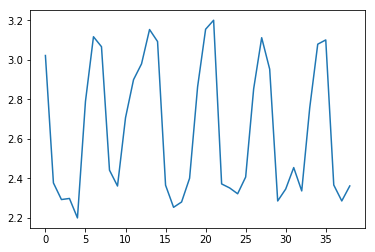

In [38]:
plt.plot(testpreds[129])

In [39]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))

In [40]:
preddf=preddf.unstack().reset_index()

In [41]:
preddf.columns=['date','store','transformed_visitors']

In [42]:
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)

In [43]:
preddf['visitors']=np.expm1(preddf['transformed_visitors'])

In [44]:
preddf=preddf.set_index(preddf['id'])

In [45]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.167226   
air_0164b9927d20bcc3_2017-04-23              1.170005   
air_0241aa3964b7f861_2017-04-23              2.298616   
air_0328696196e46f18_2017-04-23              2.029956   
air_034a3d5b40d5b1b1_2017-04-23              3.428507   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.734022  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.222010  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.960386  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.613754  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.830581

In [48]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [49]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [51]:
submission.to_csv("../submission/2001_log_run_1.csv.gz",compression='gzip')